## Regression models for occupancy estimation based on $CO_2$

In [55]:
import math
import matplotlib.pylab as pylab
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from Artificial_Neural_Network_Classification import ANN_classify
from Artificial_Neural_Network_Regression import *
from Decision_Tree_Regression import Decision_Tree_Regression
from Get_Data_From_API import get_data_from_API
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium'}
pylab.rcParams.update(params)
import warnings

warnings.filterwarnings('ignore')
np.random.seed(48)

def plot_confusion_matrix(confusion_matrix_calculated,
                          accuracy,
                          model_name):
    matrix_percentage = confusion_matrix_calculated.astype(dtype=np.float32)

    rows = confusion_matrix_calculated.shape[0]
    columns = confusion_matrix_calculated.shape[1]

    for column in range(columns):
        for row in range(rows):
            matrix_percentage[row, column] = matrix_percentage[row, column] / \
                                             np.sum(confusion_matrix_calculated, axis=1)[row]

    plt.figure(figsize=(9, 9))
    sns.heatmap(matrix_percentage, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = f'Accuracy Score for {model_name}: {np.round(accuracy, 4)*100} %'
    plt.title(all_sample_title, size=15)
    plt.show()


def filter_measurements_data(measure, name, business_hours, weekends):
    
    if name == 'co2':
        measure = measure.shift(1)
        measure = measure.fillna(method='bfill')
        
    if business_hours:
        measure = measure.between_time('8:00', '19:00')

    if weekends:
        measure = measure[measure.index.dayofweek < 5]

    measure = measure.rename(columns={'value': f'{name}'})

    return measure


def create_dataset(occupancy_data, *args):
    data_set = pd.DataFrame()
    measurements = occupancy_data

    for ar in args:
        data_set = measurements.join(ar, how='inner')
        measurements = data_set

    return data_set


def prepare_data(data_set, size_window):
    batches_list = []
    labels_list = []
    features_number = data_set.shape[1] - 1
    for idx in range(len(data_set) - size_window - 1):
        batches_list.append(data_set[idx: idx + size_window, 1:features_number + 1])
        labels_list.append(data_set[idx + size_window, 0])
    return np.array(batches_list), np.array(labels_list)

## Occupancy estimation

Two models will be applied to the problem of occupancy estimation:

* Classification problem - Room is occupied or not
* Regression problem - How many people are in the room

In [56]:
data = pd.read_csv('data_co2_occ_full_numerical.csv', sep=';', decimal=',', index_col=0)
data.index = pd.to_datetime(data.index, utc=True)

In [57]:
# account for the lag in co2 increase and people entering the room

data['co2'] = data['co2'].shift(2)
data['co2'] = data['co2'].fillna(method='bfill')

data['noise'] = data['noise'].shift(2)
data['noise'] = data['noise'].fillna(method='bfill')

In [58]:
data_co2_room1 = data.loc[data['room'] == 1, ['occupancy', 'co2']]
data_co2_room2 = data.loc[data['room'] == 2, ['occupancy', 'co2']]
data_co2_room3 = data.loc[data['room'] == 3, ['occupancy', 'co2']]
data_co2_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2']]
data_co2_room5 = data.loc[data['room'] == 5, ['occupancy', 'co2']]

data_co2_noise_room1 = data.loc[data['room'] == 1, ['occupancy', 'co2', 'noise']]
data_co2_noise_room2 = data.loc[data['room'] == 2, ['occupancy', 'co2', 'noise']]
data_co2_noise_room3 = data.loc[data['room'] == 3, ['occupancy', 'co2', 'noise']]
data_co2_noise_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2', 'noise']]
data_co2_noise_room5 = data.loc[data['room'] == 5, ['occupancy', 'co2', 'noise']]

data_co2_noise_humidity_temperature_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2', 'noise', 'humidity', 'temperature']]

data_co2_full = data[['occupancy', 'co2']]
data_co2_noise_full = data[['occupancy', 'co2', 'noise']]

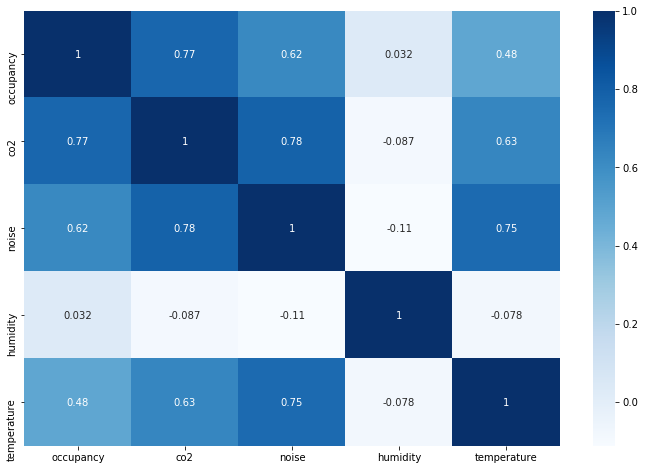

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(data_co2_noise_humidity_temperature_room4.corr(),cmap='Blues',annot=True)

### Visualize relationship for 2 day

1 - room occupied
0 - room not occupied


Text(0.5, 1, 'Occupancy vs CO_2')

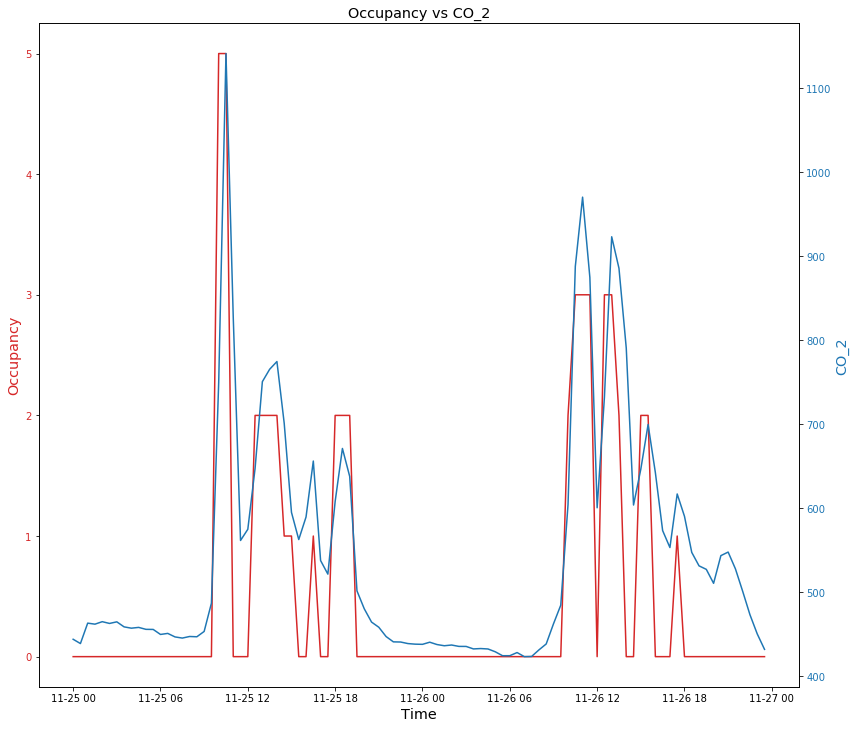

In [6]:
data_co2_room = data_co2_room4

data_cut = (data_co2_room.loc[(data_co2_room.index.day==25) & (data_co2_room.index.month==11)]).append(data_co2_room.loc[(data_co2_room.index.day==26) & (data_co2_room.index.month==11)])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupancy', color=color)

ax1.plot(data_cut['occupancy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CO_2', color=color)

ax2.plot(data_cut['co2'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Occupancy vs CO_2')

Text(0.5, 1, 'Occupancy vs Sound')

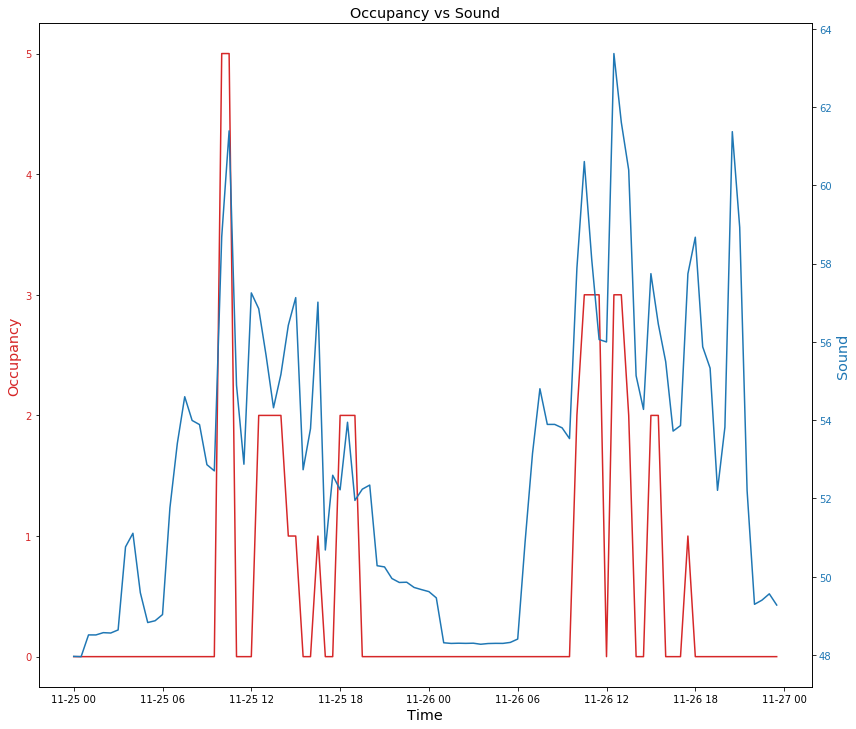

In [7]:
data_noise_room = data_co2_noise_room4

data_cut = (data_noise_room.loc[(data_noise_room.index.day==25) & (data_noise_room.index.month==11)]).append(data_noise_room.loc[(data_noise_room.index.day==26) & (data_noise_room.index.month==11)])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupancy', color=color)

ax1.plot(data_cut['occupancy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sound', color=color)

ax2.plot(data_cut['noise'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Occupancy vs Sound')

#
# ax2.set_ylabel('Noise', color=color)
#
# ax2.plot(data['noise'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.title(f'Occupancy vs Noise')

## How imbalanced is the dataset?

In [8]:
count_class = data_co2_room4['occupancy'].value_counts()
count_class

0    565
1     45
2     42
3     25
5     14
4     13
Name: occupancy, dtype: int64

Text(0.5, 1.0, 'Dataset imbalance visualization')

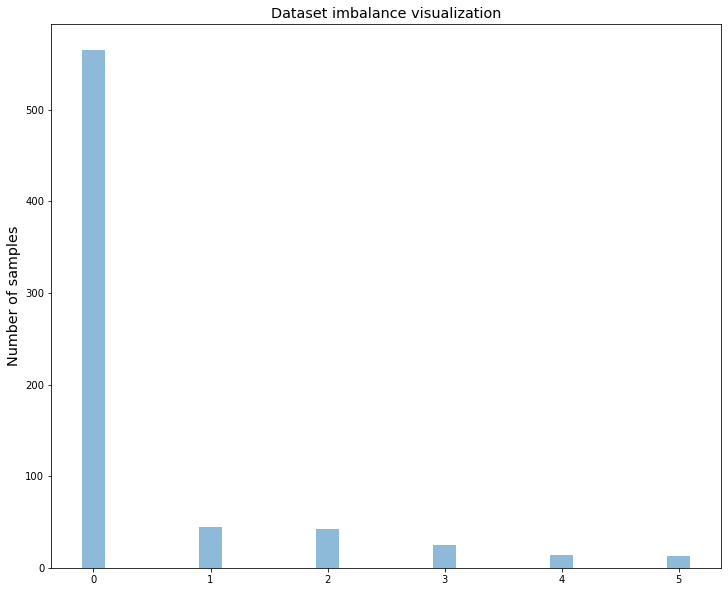

In [9]:
plt.bar(count_class.index, [count_class.loc[0], count_class.loc[1], count_class.loc[2], count_class.loc[3],
                            count_class.loc[4], count_class.loc[5]], width=0.2, align='center', alpha=0.5)

plt.ylabel('Number of samples')
plt.title('Dataset imbalance visualization')

Scale and normalize feature data

In [10]:
data = data_co2_room4
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

## Estimation models 

In [52]:
max_depth = 6
n_estimators = 150

R2_DT, MSE_DT, prediction_DT, y_test_DT = Decision_Tree_Regression(data[:, 1:no_features + 1].reshape(-1, no_features),
                                                        data[:, 0].reshape(-1, 1), max_depth, n_estimators, 'plot', 'measure', 'occ')

# prediction_DT = np.round(prediction_DT, 0)

fitness_DT = prediction_DT2.T == y_test_DT.T
good_pred_DT = np.sum(fitness_DT)
bad_pred_DT = fitness_DT.shape[1] - np.sum(fitness_DT)

exact_accuracy_DT = good_pred_DT / (good_pred_DT + bad_pred_DT)

residualsDT = np.abs(np.round(y_test_DT.T - prediction_DT2.T, 0))

mean_errorDT = np.mean(residualsDT)

pd.DataFrame([R2_DT, MSE_DT, exact_accuracy_DT, mean_errorDT], columns=['Evaluation'], index=['R2', 'MSE', 'Accuarcy', 'mean'])

,Evaluation
R2,0.256543
MSE,0.860872
Accuarcy,0.617021
mean,0.400000


In [54]:
prediction_DT2.T == y_test_DT.T

array([[False,  True,  True,  True,  True,  True, False,  True,  True,
        False, False,  True, False,  True,  True, False,  True,  True,
        False,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,
        False, False,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,
      

Text(0.5, 1.0, 'Real vs predicted using MLP')

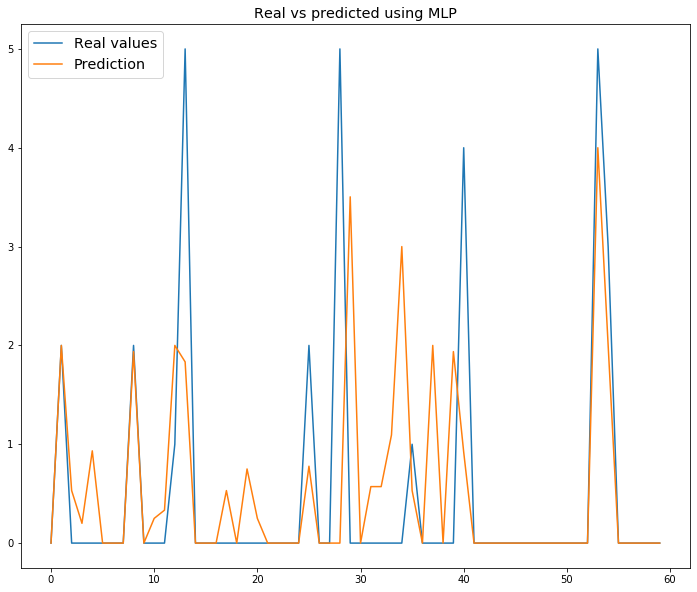

In [46]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test_DT[slice_start:slice_end])
p2 = plt.plot(prediction_DT[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using MLP')

In [53]:
X_train_SVR, X_test_SVR, y_train_SVR, y_test_SVR = train_test_split(data[:, 1:no_features + 1], data[:, 0],
                                                                    test_size=1 / 3, random_state=42, shuffle=True)

model_SVR = SVR(C=1.0, epsilon=0.2)

features_number = X_train_SVR.shape[1]

y_train_SVR = y_train_SVR.astype('int')
y_test_SVR = y_test_SVR.astype('int')

model_SVR.fit(X_train_SVR.reshape(-1, features_number), y_train_SVR.reshape(-1, 1))
prediction_SVR = model_SVR.predict(X_test_SVR.reshape(-1, features_number))
R2_SVR = model_SVR.score(X_test_SVR, y_test_SVR)
MSE_SVR = math.sqrt(mean_squared_error(y_test_SVR, prediction_SVR))


prediction_SVR2 = np.round(prediction_SVR, 0)

fitness_SVR = prediction_SVR2.T == y_test_SVR.T
good_predSVR = np.sum(fitness_SVR)
bad_predSVR = fitness_SVR.shape[0] - np.sum(fitness_SVR)

exact_accuracy_SVR = good_predSVR / (good_predSVR + bad_predSVR)

residualsSVR = np.abs(np.round(y_test_SVR.T - prediction_SVR.T, 0))

mean_errorSVR = np.mean(residualsSVR)

pd.DataFrame([R2_SVR, MSE_SVR, exact_accuracy_SVR, mean_errorSVR], columns=['Evaluation'], index=['R2', 'MSE', 'Accuarcy', 'mean'])

,Evaluation
R2,0.488632
MSE,0.713966
Accuarcy,0.000000
mean,0.285106


Text(0.5, 1.0, 'Real vs predicted using MLP')

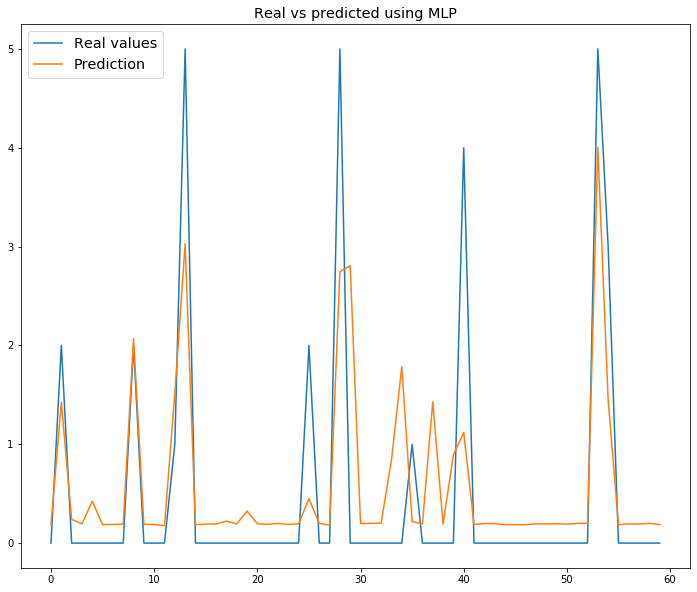

In [49]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test_SVR[slice_start:slice_end])
p2 = plt.plot(prediction_SVR[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using MLP')

In [163]:
number_of_epochs = 1500
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [164]:
number_of_nodes_MLP = 64
model_MLP = MLP(window_size, no_features, number_of_nodes_MLP)
training_history_MLP = model_MLP.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_MLP = model_MLP.predict(X_test)
MSE_MLP_co2_room4, R2_MLP_co2_room4, residuals_MLP_co2_room4, accuracy_MLP_co2_room4, mean_error_MLP_co2_room4 = model_MLP.evaluate(prediction_MLP, X_test, y_test)


Train on 447 samples, validate on 224 samples
Epoch 1/1500
447/447 [==============================] - 0s 738us/step - loss: 0.9618 - val_loss: 1.1727
Epoch 2/1500
447/447 [==============================] - 0s 54us/step - loss: 0.9197 - val_loss: 1.1146
Epoch 3/1500
447/447 [==============================] - 0s 62us/step - loss: 0.8807 - val_loss: 1.0663
Epoch 4/1500
447/447 [==============================] - 0s 67us/step - loss: 0.8386 - val_loss: 1.0315
Epoch 5/1500
447/447 [==============================] - 0s 56us/step - loss: 0.8288 - val_loss: 1.0064
Epoch 6/1500
447/447 [==============================] - 0s 60us/step - loss: 0.8035 - val_loss: 0.9895
Epoch 7/1500
447/447 [==============================] - 0s 56us/step - loss: 0.7975 - val_loss: 0.9777
Epoch 8/1500
447/447 [==============================] - 0s 60us/step - loss: 0.7861 - val_loss: 0.9660
Epoch 9/1500
447/447 [==============================] - 0s 58us/step - loss: 0.7723 - val_loss: 0.9556
Epoch 10/1500
447/447 [===

447/447 [==============================] - 0s 54us/step - loss: 0.5552 - val_loss: 0.7169
Epoch 158/1500
447/447 [==============================] - 0s 65us/step - loss: 0.5480 - val_loss: 0.7185
Epoch 159/1500
447/447 [==============================] - 0s 56us/step - loss: 0.5440 - val_loss: 0.7195
Epoch 160/1500
447/447 [==============================] - 0s 62us/step - loss: 0.5475 - val_loss: 0.7174
Epoch 161/1500
447/447 [==============================] - 0s 62us/step - loss: 0.5342 - val_loss: 0.7162
Epoch 162/1500
447/447 [==============================] - 0s 60us/step - loss: 0.5491 - val_loss: 0.7151
Epoch 163/1500
447/447 [==============================] - 0s 56us/step - loss: 0.5422 - val_loss: 0.7166
Epoch 164/1500
447/447 [==============================] - 0s 62us/step - loss: 0.5502 - val_loss: 0.7174
Epoch 165/1500
447/447 [==============================] - 0s 58us/step - loss: 0.5457 - val_loss: 0.7184
Epoch 166/1500
447/447 [==============================] - 0s 56us/step

Text(0.5, 1.0, 'Real vs predicted using MLP')

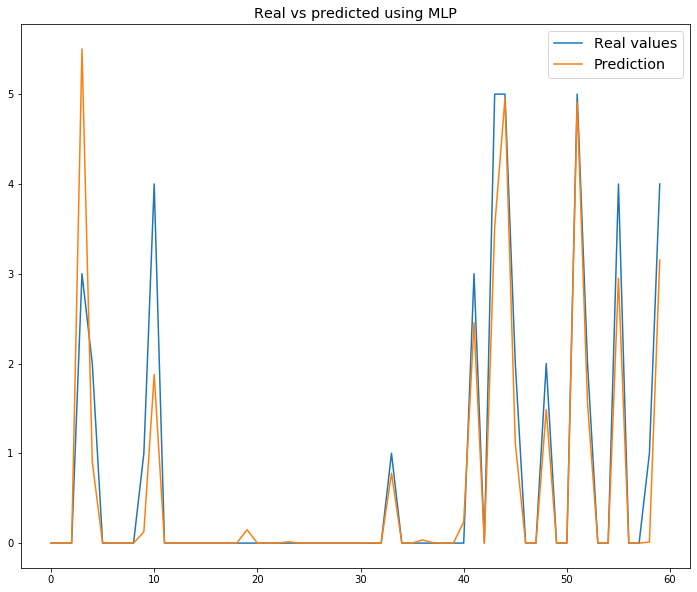

In [165]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_MLP[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using MLP')

In [166]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM_co2_room4 = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM_co2_room4 = model_LSTM.predict(X_test)
MSE_LSTM_co2_room4, R2_LSTM_co2_room4, residuals_LSTM_co2_room4, accuracy_LSTM_co2_room4, mean_error_LSTM_co2_room4 = model_LSTM.evaluate(prediction_LSTM_co2_room4, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1500
447/447 [==============================] - 1s 3ms/step - loss: 0.9934 - val_loss: 1.2130
Epoch 2/1500
447/447 [==============================] - 0s 590us/step - loss: 0.9826 - val_loss: 1.1946
Epoch 3/1500
447/447 [==============================] - 0s 558us/step - loss: 0.9495 - val_loss: 1.1735
Epoch 4/1500
447/447 [==============================] - 0s 581us/step - loss: 0.9477 - val_loss: 1.1523
Epoch 5/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.9293 - val_loss: 1.1329
Epoch 6/1500
447/447 [==============================] - 0s 652us/step - loss: 0.9062 - val_loss: 1.1163
Epoch 7/1500
447/447 [==============================] - 0s 793us/step - loss: 0.8892 - val_loss: 1.1032
Epoch 8/1500
447/447 [==============================] - 0s 827us/step - loss: 0.8898 - val_loss: 1.0912
Epoch 9/1500
447/447 [==============================] - 0s 701us/step - loss: 0.8701 - val_loss: 1.0816
Epoch 10/1500
447/447 

Epoch 79/1500
447/447 [==============================] - 0s 951us/step - loss: 0.7327 - val_loss: 0.9289
Epoch 80/1500
447/447 [==============================] - 0s 544us/step - loss: 0.7350 - val_loss: 0.9274
Epoch 81/1500
447/447 [==============================] - 0s 960us/step - loss: 0.7335 - val_loss: 0.9262
Epoch 82/1500
447/447 [==============================] - 0s 548us/step - loss: 0.7375 - val_loss: 0.9252
Epoch 83/1500
447/447 [==============================] - 0s 561us/step - loss: 0.7333 - val_loss: 0.9240
Epoch 84/1500
447/447 [==============================] - 0s 920us/step - loss: 0.7217 - val_loss: 0.9230
Epoch 85/1500
447/447 [==============================] - 0s 779us/step - loss: 0.7247 - val_loss: 0.9220
Epoch 86/1500
447/447 [==============================] - 0s 652us/step - loss: 0.7219 - val_loss: 0.9208
Epoch 87/1500
447/447 [==============================] - 0s 705us/step - loss: 0.7242 - val_loss: 0.9191
Epoch 88/1500
447/447 [==============================] 

447/447 [==============================] - 0s 935us/step - loss: 0.6800 - val_loss: 0.8571
Epoch 157/1500
447/447 [==============================] - 0s 516us/step - loss: 0.6706 - val_loss: 0.8564
Epoch 158/1500
447/447 [==============================] - 0s 898us/step - loss: 0.6762 - val_loss: 0.8558
Epoch 159/1500
447/447 [==============================] - 0s 520us/step - loss: 0.6779 - val_loss: 0.8546
Epoch 160/1500
447/447 [==============================] - 0s 678us/step - loss: 0.6755 - val_loss: 0.8540
Epoch 161/1500
447/447 [==============================] - 0s 784us/step - loss: 0.6763 - val_loss: 0.8531
Epoch 162/1500
447/447 [==============================] - 0s 560us/step - loss: 0.6770 - val_loss: 0.8522
Epoch 163/1500
447/447 [==============================] - 0s 896us/step - loss: 0.6706 - val_loss: 0.8513
Epoch 164/1500
447/447 [==============================] - 0s 520us/step - loss: 0.6786 - val_loss: 0.8505
Epoch 165/1500
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 512us/step - loss: 0.6337 - val_loss: 0.7772
Epoch 311/1500
447/447 [==============================] - 0s 763us/step - loss: 0.6292 - val_loss: 0.7771
Epoch 312/1500
447/447 [==============================] - 0s 702us/step - loss: 0.6411 - val_loss: 0.7768
Epoch 313/1500
447/447 [==============================] - 0s 775us/step - loss: 0.6372 - val_loss: 0.7764
Epoch 314/1500
447/447 [==============================] - 0s 707us/step - loss: 0.6252 - val_loss: 0.7761
Epoch 315/1500
447/447 [==============================] - 0s 745us/step - loss: 0.6351 - val_loss: 0.7758
Epoch 316/1500
447/447 [==============================] - 0s 683us/step - loss: 0.6397 - val_loss: 0.7751
Epoch 317/1500
447/447 [==============================] - 0s 707us/step - loss: 0.6374 - val_loss: 0.7750
Epoch 318/1500
447/447 [==============================] - 0s 741us/step - loss: 0.6260 - val_loss: 0.7746
Epoch 319/1500
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 926us/step - loss: 0.6209 - val_loss: 0.7329
Epoch 465/1500
447/447 [==============================] - 0s 540us/step - loss: 0.6135 - val_loss: 0.7325
Epoch 466/1500
447/447 [==============================] - 0s 969us/step - loss: 0.6063 - val_loss: 0.7323
Epoch 467/1500
447/447 [==============================] - 0s 527us/step - loss: 0.6143 - val_loss: 0.7321
Epoch 468/1500
447/447 [==============================] - 0s 960us/step - loss: 0.6160 - val_loss: 0.7317
Epoch 469/1500
447/447 [==============================] - 0s 536us/step - loss: 0.5991 - val_loss: 0.7316
Epoch 470/1500
447/447 [==============================] - 0s 919us/step - loss: 0.6157 - val_loss: 0.7309
Epoch 471/1500
447/447 [==============================] - 0s 542us/step - loss: 0.6165 - val_loss: 0.7303
Epoch 472/1500
447/447 [==============================] - 0s 962us/step - loss: 0.6149 - val_loss: 0.7303
Epoch 473/1500
447/447 [==============================] - 0s 

Epoch 619/1500
447/447 [==============================] - 0s 710us/step - loss: 0.5901 - val_loss: 0.7060
Epoch 620/1500
447/447 [==============================] - 0s 780us/step - loss: 0.5941 - val_loss: 0.7055
Epoch 621/1500
447/447 [==============================] - 0s 760us/step - loss: 0.6006 - val_loss: 0.7059
Epoch 622/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.5985 - val_loss: 0.7052
Epoch 623/1500
447/447 [==============================] - 0s 537us/step - loss: 0.6009 - val_loss: 0.7049
Epoch 624/1500
447/447 [==============================] - 0s 979us/step - loss: 0.5955 - val_loss: 0.7054
Epoch 625/1500
447/447 [==============================] - 0s 538us/step - loss: 0.5943 - val_loss: 0.7053
Epoch 626/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.6018 - val_loss: 0.7051
Epoch 627/1500
447/447 [==============================] - 0s 673us/step - loss: 0.5997 - val_loss: 0.7050
Epoch 628/1500
447/447 [==========================

447/447 [==============================] - 0s 586us/step - loss: 0.5839 - val_loss: 0.6911
Epoch 774/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.5844 - val_loss: 0.6917
Epoch 775/1500
447/447 [==============================] - 0s 670us/step - loss: 0.5904 - val_loss: 0.6914
Epoch 776/1500
447/447 [==============================] - 0s 916us/step - loss: 0.5894 - val_loss: 0.6924
Epoch 777/1500
447/447 [==============================] - 0s 980us/step - loss: 0.5857 - val_loss: 0.6918
Epoch 778/1500
447/447 [==============================] - 0s 829us/step - loss: 0.5777 - val_loss: 0.6927
Epoch 779/1500
447/447 [==============================] - 0s 966us/step - loss: 0.5887 - val_loss: 0.6921
Epoch 780/1500
447/447 [==============================] - 0s 605us/step - loss: 0.5888 - val_loss: 0.6914
Epoch 781/1500
447/447 [==============================] - 1s 1ms/step - loss: 0.5758 - val_loss: 0.6916
Epoch 782/1500
447/447 [==============================] - 1s 1ms/

Text(0.5, 1.0, 'Real vs predicted using LSTM')

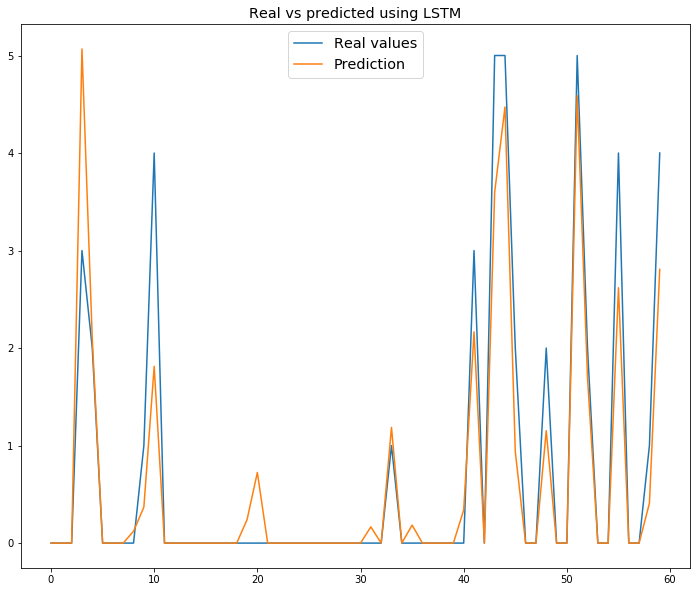

In [167]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM_co2_room4[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

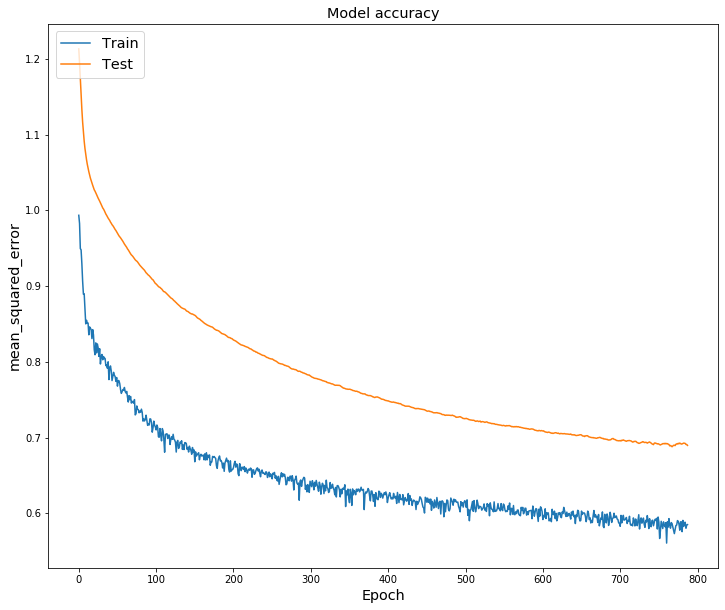

In [168]:
plt.figure(figsize=(12, 10))
plt.plot(training_history_LSTM_co2_room4.history['loss'])
plt.plot(training_history_LSTM_co2_room4.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [169]:
number_of_filters_CNN = 64
model_CNN = CNN(window_size, no_features, number_of_filters_CNN)
training_history_CNN = model_CNN.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_CNN = model_CNN.predict(X_test)
MSE_CNN_co2_room4, R2_CNN_co2_room4, residuals_CNN_co2_room4, accuracy_CNN_co2_room4, mean_error_CNN_co2_room4 = model_CNN.evaluate(prediction_CNN, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1500
447/447 [==============================] - 1s 2ms/step - loss: 1.0594 - val_loss: 1.2871
Epoch 2/1500
447/447 [==============================] - 0s 294us/step - loss: 1.0660 - val_loss: 1.2857
Epoch 3/1500
447/447 [==============================] - 0s 163us/step - loss: 1.0484 - val_loss: 1.2828
Epoch 4/1500
447/447 [==============================] - 0s 167us/step - loss: 1.0456 - val_loss: 1.2743
Epoch 5/1500
447/447 [==============================] - 0s 428us/step - loss: 1.0270 - val_loss: 1.2262
Epoch 6/1500
447/447 [==============================] - 0s 292us/step - loss: 0.9617 - val_loss: 1.1442
Epoch 7/1500
447/447 [==============================] - 0s 263us/step - loss: 0.9176 - val_loss: 1.0937
Epoch 8/1500
447/447 [==============================] - 0s 138us/step - loss: 0.8851 - val_loss: 1.0751
Epoch 9/1500
447/447 [==============================] - 0s 149us/step - loss: 0.8946 - val_loss: 1.0707
Epoch 10/1500
447/44

Text(0.5, 1.0, 'Real vs predicted using CNN')

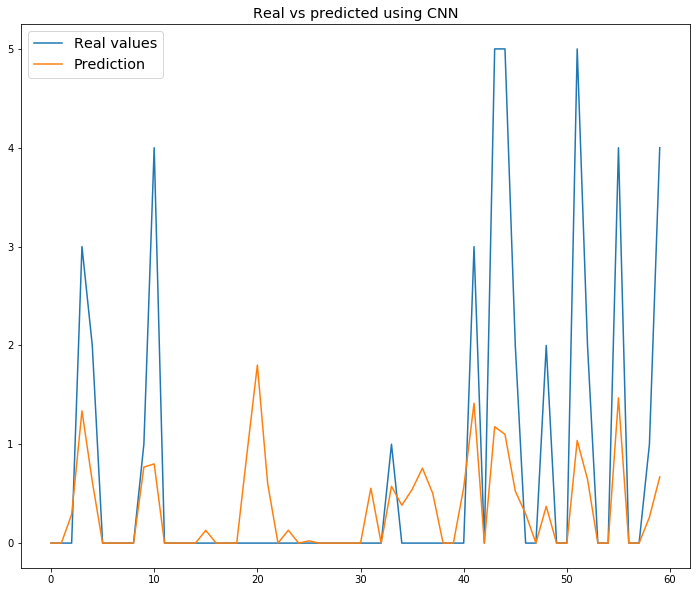

In [170]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_CNN[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using CNN')

In [171]:
number_of_filters_CNN_LSTM = 64
number_of_nodes_CNN_LSTM = 64
model_CNN_LSTM = CNN_LSTM(window_size, no_features, number_of_filters_CNN_LSTM, number_of_nodes_CNN_LSTM)
training_history_CNN_LSTM = model_CNN_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs)
prediction_CNN_LSTM = model_CNN_LSTM.predict(X_test)
MSE_CNN_LSTM_co2_room4, R2_CNN_LSTM_co2_room4, residuals_CNN_LSTM_co2_room4, accuracy_CNN_LSTM_co2_room4, mean_error_CNN_LSTM_co2_room4 = model_CNN_LSTM.evaluate(
    prediction_CNN_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1500
447/447 [==============================] - 1s 3ms/step - loss: 1.0617 - val_loss: 1.2790
Epoch 2/1500
447/447 [==============================] - 0s 273us/step - loss: 1.0528 - val_loss: 1.2757
Epoch 3/1500
447/447 [==============================] - 0s 199us/step - loss: 1.0453 - val_loss: 1.2695
Epoch 4/1500
447/447 [==============================] - 0s 437us/step - loss: 1.0406 - val_loss: 1.2568
Epoch 5/1500
447/447 [==============================] - 0s 410us/step - loss: 1.0222 - val_loss: 1.2415
Epoch 6/1500
447/447 [==============================] - 0s 232us/step - loss: 1.0159 - val_loss: 1.2261
Epoch 7/1500
447/447 [==============================] - 0s 176us/step - loss: 0.9992 - val_loss: 1.2119
Epoch 8/1500
447/447 [==============================] - 0s 156us/step - loss: 0.9879 - val_loss: 1.1996
Epoch 9/1500
447/447 [==============================] - 0s 395us/step - loss: 0.9487 - val_loss: 1.1884
Epoch 10/1500
447/44

447/447 [==============================] - 0s 400us/step - loss: 0.7130 - val_loss: 0.8704
Epoch 156/1500
447/447 [==============================] - 0s 381us/step - loss: 0.7180 - val_loss: 0.8696
Epoch 157/1500
447/447 [==============================] - 0s 173us/step - loss: 0.7070 - val_loss: 0.8693
Epoch 158/1500
447/447 [==============================] - 0s 159us/step - loss: 0.7085 - val_loss: 0.8686
Epoch 159/1500
447/447 [==============================] - 0s 163us/step - loss: 0.7149 - val_loss: 0.8678
Epoch 160/1500
447/447 [==============================] - 0s 188us/step - loss: 0.7047 - val_loss: 0.8673
Epoch 161/1500
447/447 [==============================] - 0s 422us/step - loss: 0.7120 - val_loss: 0.8670
Epoch 162/1500
447/447 [==============================] - 0s 395us/step - loss: 0.7151 - val_loss: 0.8664
Epoch 163/1500
447/447 [==============================] - 0s 178us/step - loss: 0.7183 - val_loss: 0.8653
Epoch 164/1500
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 170us/step - loss: 0.6763 - val_loss: 0.8148
Epoch 310/1500
447/447 [==============================] - 0s 167us/step - loss: 0.6807 - val_loss: 0.8142
Epoch 311/1500
447/447 [==============================] - 0s 206us/step - loss: 0.6664 - val_loss: 0.8142
Epoch 312/1500
447/447 [==============================] - 0s 398us/step - loss: 0.6721 - val_loss: 0.8141
Epoch 313/1500
447/447 [==============================] - 0s 307us/step - loss: 0.6632 - val_loss: 0.8145
Epoch 314/1500
447/447 [==============================] - 0s 154us/step - loss: 0.6640 - val_loss: 0.8150
Epoch 315/1500
447/447 [==============================] - 0s 170us/step - loss: 0.6810 - val_loss: 0.8149
Epoch 316/1500
447/447 [==============================] - 0s 165us/step - loss: 0.6800 - val_loss: 0.8146
Epoch 317/1500
447/447 [==============================] - 0s 167us/step - loss: 0.6804 - val_loss: 0.8137
Epoch 318/1500
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 404us/step - loss: 0.6503 - val_loss: 0.7814
Epoch 464/1500
447/447 [==============================] - 0s 271us/step - loss: 0.6450 - val_loss: 0.7811
Epoch 465/1500
447/447 [==============================] - 0s 170us/step - loss: 0.6393 - val_loss: 0.7806
Epoch 466/1500
447/447 [==============================] - 0s 176us/step - loss: 0.6435 - val_loss: 0.7798
Epoch 467/1500
447/447 [==============================] - 0s 156us/step - loss: 0.6462 - val_loss: 0.7794
Epoch 468/1500
447/447 [==============================] - 0s 445us/step - loss: 0.6430 - val_loss: 0.7784
Epoch 469/1500
447/447 [==============================] - 0s 431us/step - loss: 0.6362 - val_loss: 0.7785
Epoch 470/1500
447/447 [==============================] - 0s 229us/step - loss: 0.6413 - val_loss: 0.7790
Epoch 471/1500
447/447 [==============================] - 0s 185us/step - loss: 0.6474 - val_loss: 0.7786
Epoch 472/1500
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 214us/step - loss: 0.6005 - val_loss: 0.7566
Epoch 618/1500
447/447 [==============================] - 0s 170us/step - loss: 0.5990 - val_loss: 0.7566
Epoch 619/1500
447/447 [==============================] - 0s 173us/step - loss: 0.5936 - val_loss: 0.7549
Epoch 620/1500
447/447 [==============================] - 0s 180us/step - loss: 0.5999 - val_loss: 0.7550
Epoch 621/1500
447/447 [==============================] - 0s 205us/step - loss: 0.5888 - val_loss: 0.7542
Epoch 622/1500
447/447 [==============================] - 0s 396us/step - loss: 0.5918 - val_loss: 0.7548
Epoch 623/1500
447/447 [==============================] - 0s 331us/step - loss: 0.6008 - val_loss: 0.7543
Epoch 624/1500
447/447 [==============================] - 0s 176us/step - loss: 0.5983 - val_loss: 0.7546
Epoch 625/1500
447/447 [==============================] - 0s 170us/step - loss: 0.5906 - val_loss: 0.7560
Epoch 626/1500
447/447 [==============================] - 0s 

Text(0.5, 1.0, 'Real vs predicted using CNN LSTM')

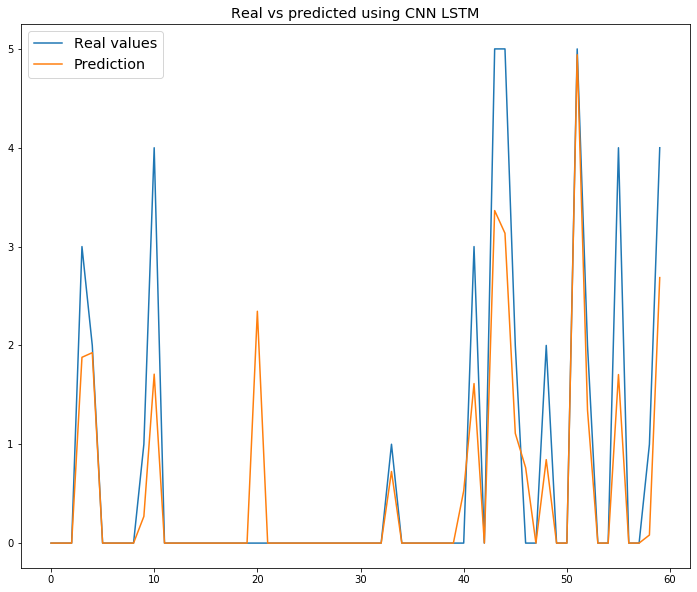

In [172]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_CNN_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using CNN LSTM')

### Adding sound

In [173]:
data = data_co2_noise_room4
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

In [174]:
number_of_epochs = 1500
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [175]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM_co2_noise_room4 = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room4, R2_LSTM_co2_noise_room4, residuals_LSTM_co2_noise_room4, accuracy_LSTM_co2_noise_room4, mean_error_LSTM_co2_noise_room4 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1500
447/447 [==============================] - 1s 3ms/step - loss: 1.0382 - val_loss: 1.2712
Epoch 2/1500
447/447 [==============================] - 0s 552us/step - loss: 1.0459 - val_loss: 1.2530
Epoch 3/1500
447/447 [==============================] - 0s 552us/step - loss: 1.0059 - val_loss: 1.2307
Epoch 4/1500
447/447 [==============================] - 0s 704us/step - loss: 0.9724 - val_loss: 1.2080
Epoch 5/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.9629 - val_loss: 1.1874
Epoch 6/1500
447/447 [==============================] - 0s 874us/step - loss: 0.9445 - val_loss: 1.1682
Epoch 7/1500
447/447 [==============================] - 0s 651us/step - loss: 0.9303 - val_loss: 1.1524
Epoch 8/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.9125 - val_loss: 1.1386
Epoch 9/1500
447/447 [==============================] - 0s 651us/step - loss: 0.8870 - val_loss: 1.1274
Epoch 10/1500
447/447 [=

447/447 [==============================] - 0s 963us/step - loss: 0.7634 - val_loss: 0.9609
Epoch 80/1500
447/447 [==============================] - 0s 556us/step - loss: 0.7668 - val_loss: 0.9596
Epoch 81/1500
447/447 [==============================] - 0s 978us/step - loss: 0.7604 - val_loss: 0.9581
Epoch 82/1500
447/447 [==============================] - 0s 538us/step - loss: 0.7571 - val_loss: 0.9576
Epoch 83/1500
447/447 [==============================] - 0s 963us/step - loss: 0.7649 - val_loss: 0.9566
Epoch 84/1500
447/447 [==============================] - 0s 559us/step - loss: 0.7494 - val_loss: 0.9551
Epoch 85/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.7592 - val_loss: 0.9541
Epoch 86/1500
447/447 [==============================] - 0s 527us/step - loss: 0.7574 - val_loss: 0.9533
Epoch 87/1500
447/447 [==============================] - 0s 966us/step - loss: 0.7550 - val_loss: 0.9519
Epoch 88/1500
447/447 [==============================] - 0s 537us/step 

447/447 [==============================] - 0s 958us/step - loss: 0.7024 - val_loss: 0.8852
Epoch 158/1500
447/447 [==============================] - 0s 583us/step - loss: 0.6928 - val_loss: 0.8843
Epoch 159/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.7027 - val_loss: 0.8838
Epoch 160/1500
447/447 [==============================] - 0s 540us/step - loss: 0.6838 - val_loss: 0.8831
Epoch 161/1500
447/447 [==============================] - 0s 921us/step - loss: 0.6991 - val_loss: 0.8823
Epoch 162/1500
447/447 [==============================] - 0s 606us/step - loss: 0.6918 - val_loss: 0.8813
Epoch 163/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.6937 - val_loss: 0.8809
Epoch 164/1500
447/447 [==============================] - 0s 537us/step - loss: 0.6942 - val_loss: 0.8799
Epoch 165/1500
447/447 [==============================] - 0s 990us/step - loss: 0.6940 - val_loss: 0.8794
Epoch 166/1500
447/447 [==============================] - 0s 539u

Epoch 312/1500
447/447 [==============================] - 1s 1ms/step - loss: 0.6278 - val_loss: 0.7695
Epoch 313/1500
447/447 [==============================] - 0s 564us/step - loss: 0.6246 - val_loss: 0.7686
Epoch 314/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.6245 - val_loss: 0.7683
Epoch 315/1500
447/447 [==============================] - 0s 547us/step - loss: 0.6220 - val_loss: 0.7686
Epoch 316/1500
447/447 [==============================] - 1s 1ms/step - loss: 0.6154 - val_loss: 0.7679
Epoch 317/1500
447/447 [==============================] - 0s 1000us/step - loss: 0.6165 - val_loss: 0.7670
Epoch 318/1500
447/447 [==============================] - 0s 737us/step - loss: 0.6206 - val_loss: 0.7660
Epoch 319/1500
447/447 [==============================] - 0s 982us/step - loss: 0.6216 - val_loss: 0.7649
Epoch 320/1500
447/447 [==============================] - 0s 671us/step - loss: 0.6184 - val_loss: 0.7640
Epoch 321/1500
447/447 [===========================

447/447 [==============================] - 0s 560us/step - loss: 0.5418 - val_loss: 0.6781
Epoch 467/1500
447/447 [==============================] - 1s 1ms/step - loss: 0.5310 - val_loss: 0.6859
Epoch 468/1500
447/447 [==============================] - 0s 936us/step - loss: 0.5415 - val_loss: 0.6773
Epoch 469/1500
447/447 [==============================] - 0s 915us/step - loss: 0.5397 - val_loss: 0.6850
Epoch 470/1500
447/447 [==============================] - 1s 1ms/step - loss: 0.5410 - val_loss: 0.6805
Epoch 471/1500
447/447 [==============================] - 0s 913us/step - loss: 0.5412 - val_loss: 0.6829
Epoch 472/1500
447/447 [==============================] - 0s 772us/step - loss: 0.5433 - val_loss: 0.6777
Epoch 473/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.5369 - val_loss: 0.6815
Epoch 474/1500
447/447 [==============================] - 0s 726us/step - loss: 0.5259 - val_loss: 0.6789
Epoch 475/1500
447/447 [==============================] - 0s 828us/

Epoch 544/1500
447/447 [==============================] - 0s 752us/step - loss: 0.5119 - val_loss: 0.6490
Epoch 545/1500
447/447 [==============================] - 0s 786us/step - loss: 0.5050 - val_loss: 0.6541
Epoch 546/1500
447/447 [==============================] - 0s 979us/step - loss: 0.5049 - val_loss: 0.6520
Epoch 547/1500
447/447 [==============================] - 0s 541us/step - loss: 0.5038 - val_loss: 0.6518
Epoch 548/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.5045 - val_loss: 0.6587
Epoch 549/1500
447/447 [==============================] - 0s 537us/step - loss: 0.5062 - val_loss: 0.6562
Epoch 550/1500
447/447 [==============================] - 0s 989us/step - loss: 0.4983 - val_loss: 0.6492
Epoch 551/1500
447/447 [==============================] - 0s 560us/step - loss: 0.4964 - val_loss: 0.6508
Epoch 552/1500
447/447 [==============================] - 0s 1ms/step - loss: 0.5028 - val_loss: 0.6536
Epoch 553/1500
447/447 [==========================

Text(0.5, 1.0, 'Real vs predicted using CNN LSTM')

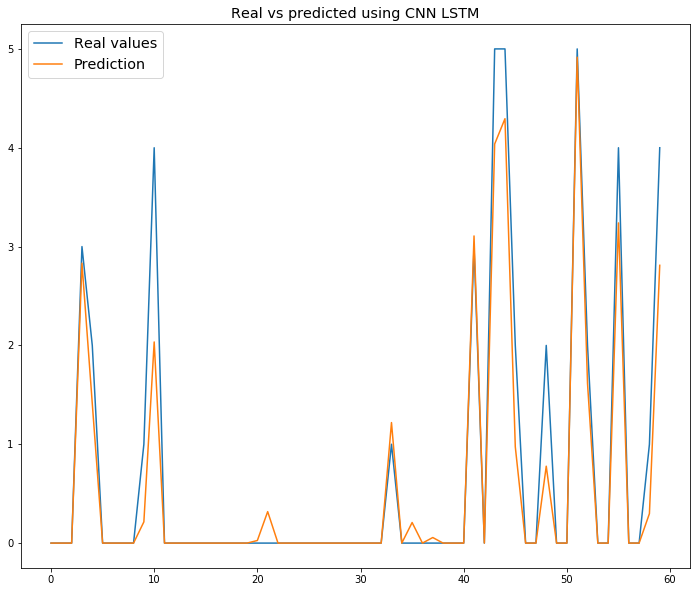

In [176]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

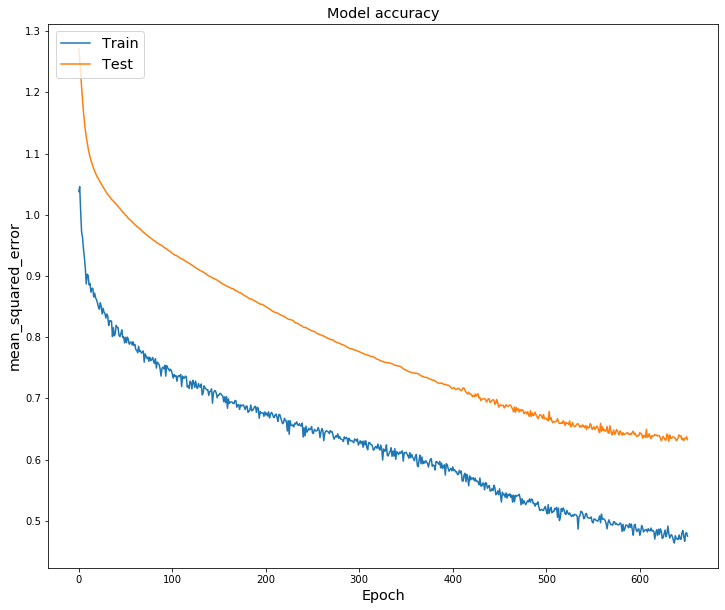

In [177]:
plt.figure(figsize=(12, 10))
plt.plot(training_history_LSTM_co2_noise_room4.history['loss'])
plt.plot(training_history_LSTM_co2_noise_room4.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [178]:
pd.DataFrame([[MSE_MLP_co2_room4, R2_MLP_co2_room4, accuracy_MLP_co2_room4, mean_error_MLP_co2_room4],
              [MSE_LSTM_co2_room4, R2_LSTM_co2_room4, accuracy_LSTM_co2_room4, mean_error_LSTM_co2_room4],
              [MSE_CNN_co2_room4, R2_CNN_co2_room4, accuracy_CNN_co2_room4, mean_error_CNN_co2_room4],
              [MSE_CNN_LSTM_co2_room4, R2_CNN_LSTM_co2_room4, accuracy_CNN_LSTM_co2_room4, mean_error_CNN_LSTM_co2_room4], 
              [MSE_LSTM_co2_noise_room4, R2_LSTM_co2_noise_room4, accuracy_LSTM_co2_noise_room4, mean_error_LSTM_co2_noise_room4]],
             columns=['MSE', 'R2', 'accuracy', 'mean_error'], index=['MPL', 'LSTM', 'CNN', 'CNN_LSTM', 'LSTM + noise'])

,MSE,R2,accuracy,mean_error
MPL,0.706977,0.643784,0.776786,0.308036
LSTM,0.683505,0.671064,0.816964,0.263393
CNN,1.033874,0.213888,0.674107,0.531250
CNN_LSTM,0.750048,0.609441,0.750000,0.357143
LSTM + noise,0.619204,0.716110,0.803571,0.263393


## Room 1 
### $CO_2$ only

In [68]:
data = data_co2_room1
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 800
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [70]:
R2_LSTM_co2_room1

0.2044482681183405

In [71]:
MSE_LSTM_co2_room1

0.5946450957230159

In [72]:
accuracy_LSTM_co2_room1

0.8214285714285714

In [73]:
mean_error_LSTM_co2_room1

0.26339285714285715

In [69]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_room1, R2_LSTM_co2_room1, residuals_LSTM_co2_room1, accuracy_LSTM_co2_room1, mean_error_LSTM_co2_room1 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/800
447/447 [==============================] - 1s 2ms/step - loss: 0.5090 - val_loss: 0.6877
Epoch 2/800
447/447 [==============================] - 0s 527us/step - loss: 0.4968 - val_loss: 0.6787
Epoch 3/800
447/447 [==============================] - 0s 518us/step - loss: 0.4862 - val_loss: 0.6691
Epoch 4/800
447/447 [==============================] - 0s 511us/step - loss: 0.4681 - val_loss: 0.6610
Epoch 5/800
447/447 [==============================] - 0s 518us/step - loss: 0.4848 - val_loss: 0.6531
Epoch 6/800
447/447 [==============================] - 0s 520us/step - loss: 0.4673 - val_loss: 0.6471
Epoch 7/800
447/447 [==============================] - 0s 966us/step - loss: 0.4803 - val_loss: 0.6423
Epoch 8/800
447/447 [==============================] - 0s 511us/step - loss: 0.4711 - val_loss: 0.6391
Epoch 9/800
447/447 [==============================] - ETA: 0s - loss: 0.456 - 0s 759us/step - loss: 0.4660 - val_loss: 0.6372
Epoch

447/447 [==============================] - 0s 799us/step - loss: 0.4527 - val_loss: 0.6133
Epoch 80/800
447/447 [==============================] - 0s 502us/step - loss: 0.4564 - val_loss: 0.6128
Epoch 81/800
447/447 [==============================] - 0s 515us/step - loss: 0.4587 - val_loss: 0.6121
Epoch 82/800
447/447 [==============================] - 0s 848us/step - loss: 0.4353 - val_loss: 0.6130
Epoch 83/800
447/447 [==============================] - 0s 506us/step - loss: 0.4546 - val_loss: 0.6126
Epoch 84/800
447/447 [==============================] - 0s 687us/step - loss: 0.4538 - val_loss: 0.6125
Epoch 85/800
447/447 [==============================] - 0s 667us/step - loss: 0.4529 - val_loss: 0.6121
Epoch 86/800
447/447 [==============================] - 0s 511us/step - loss: 0.4446 - val_loss: 0.6120
Epoch 87/800
447/447 [==============================] - 0s 875us/step - loss: 0.4461 - val_loss: 0.6125
Epoch 88/800
447/447 [==============================] - 0s 527us/step - loss:

447/447 [==============================] - 0s 498us/step - loss: 0.4468 - val_loss: 0.6029
Epoch 158/800
447/447 [==============================] - 0s 834us/step - loss: 0.4576 - val_loss: 0.6026
Epoch 159/800
447/447 [==============================] - 0s 547us/step - loss: 0.4511 - val_loss: 0.6027
Epoch 160/800
447/447 [==============================] - 0s 875us/step - loss: 0.4508 - val_loss: 0.6022
Epoch 161/800
447/447 [==============================] - 0s 515us/step - loss: 0.4563 - val_loss: 0.6021
Epoch 162/800
447/447 [==============================] - 0s 1ms/step - loss: 0.4511 - val_loss: 0.6022
Epoch 163/800
447/447 [==============================] - 0s 569us/step - loss: 0.4535 - val_loss: 0.6022
Epoch 164/800
447/447 [==============================] - 0s 1ms/step - loss: 0.4489 - val_loss: 0.6019
Epoch 165/800
447/447 [==============================] - 0s 498us/step - loss: 0.4486 - val_loss: 0.6021
Epoch 166/800
447/447 [==============================] - 0s 855us/step - 

447/447 [==============================] - 0s 511us/step - loss: 0.4488 - val_loss: 0.5970
Epoch 236/800
447/447 [==============================] - 0s 921us/step - loss: 0.4474 - val_loss: 0.5970
Epoch 237/800
447/447 [==============================] - 0s 674us/step - loss: 0.4444 - val_loss: 0.5969
Epoch 238/800
447/447 [==============================] - 0s 779us/step - loss: 0.4476 - val_loss: 0.5970
Epoch 239/800
447/447 [==============================] - 0s 761us/step - loss: 0.4433 - val_loss: 0.5970
Epoch 240/800
447/447 [==============================] - 0s 625us/step - loss: 0.4445 - val_loss: 0.5986
Epoch 241/800
447/447 [==============================] - 0s 921us/step - loss: 0.4491 - val_loss: 0.5988
Epoch 242/800
447/447 [==============================] - 0s 500us/step - loss: 0.4469 - val_loss: 0.5986
Epoch 243/800
447/447 [==============================] - 0s 908us/step - loss: 0.4467 - val_loss: 0.5981
Epoch 244/800
447/447 [==============================] - 0s 511us/ste

#### Adding sound

In [59]:
data = data_co2_noise_room1
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [64]:
R2_LSTM_co2_noise_room1

0.22113202133758847

In [65]:
MSE_LSTM_co2_noise_room1

0.5894933130059924

In [66]:
accuracy_LSTM_co2_noise_room1

0.8258928571428571

In [67]:
mean_error_LSTM_co2_noise_room1

0.24553571428571427

In [63]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room1, R2_LSTM_co2_noise_room1, residuals_LSTM_co2_noise_room1, accuracy_LSTM_co2_noise_room1, mean_error_LSTM_co2_noise_room1 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 2ms/step - loss: 0.5349 - val_loss: 0.7162
Epoch 2/1200
447/447 [==============================] - 0s 500us/step - loss: 0.5300 - val_loss: 0.7145
Epoch 3/1200
447/447 [==============================] - 0s 493us/step - loss: 0.5195 - val_loss: 0.7123
Epoch 4/1200
447/447 [==============================] - 0s 491us/step - loss: 0.5231 - val_loss: 0.7080
Epoch 5/1200
447/447 [==============================] - 0s 486us/step - loss: 0.5084 - val_loss: 0.7016
Epoch 6/1200
447/447 [==============================] - 0s 484us/step - loss: 0.5021 - val_loss: 0.6950
Epoch 7/1200
447/447 [==============================] - 0s 491us/step - loss: 0.5065 - val_loss: 0.6865
Epoch 8/1200
447/447 [==============================] - 0s 484us/step - loss: 0.4937 - val_loss: 0.6785
Epoch 9/1200
447/447 [==============================] - 0s 484us/step - loss: 0.4812 - val_loss: 0.6714
Epoch 10/1200
447/44

447/447 [==============================] - 0s 500us/step - loss: 0.4587 - val_loss: 0.6037
Epoch 79/1200
447/447 [==============================] - 0s 837us/step - loss: 0.4518 - val_loss: 0.6030
Epoch 80/1200
447/447 [==============================] - 0s 513us/step - loss: 0.4489 - val_loss: 0.6024
Epoch 81/1200
447/447 [==============================] - 0s 614us/step - loss: 0.4469 - val_loss: 0.6024
Epoch 82/1200
447/447 [==============================] - 0s 689us/step - loss: 0.4461 - val_loss: 0.6024
Epoch 83/1200
447/447 [==============================] - 0s 500us/step - loss: 0.4533 - val_loss: 0.6033
Epoch 84/1200
447/447 [==============================] - 0s 823us/step - loss: 0.4576 - val_loss: 0.6031
Epoch 85/1200
447/447 [==============================] - 0s 493us/step - loss: 0.4453 - val_loss: 0.6023
Epoch 86/1200
447/447 [==============================] - 0s 716us/step - loss: 0.4542 - val_loss: 0.6018
Epoch 87/1200
447/447 [==============================] - 0s 600us/ste

447/447 [==============================] - 0s 884us/step - loss: 0.4497 - val_loss: 0.5950
Epoch 156/1200
447/447 [==============================] - 0s 776us/step - loss: 0.4509 - val_loss: 0.5938
Epoch 157/1200
447/447 [==============================] - 0s 587us/step - loss: 0.4529 - val_loss: 0.5931
Epoch 158/1200
447/447 [==============================] - 0s 696us/step - loss: 0.4528 - val_loss: 0.5928
Epoch 159/1200
447/447 [==============================] - 0s 701us/step - loss: 0.4381 - val_loss: 0.5922
Epoch 160/1200
447/447 [==============================] - 0s 515us/step - loss: 0.4395 - val_loss: 0.5932
Epoch 161/1200
447/447 [==============================] - 0s 881us/step - loss: 0.4509 - val_loss: 0.5936
Epoch 162/1200
447/447 [==============================] - 0s 495us/step - loss: 0.4553 - val_loss: 0.5936
Epoch 163/1200
447/447 [==============================] - 0s 881us/step - loss: 0.4384 - val_loss: 0.5943
Epoch 164/1200
447/447 [==============================] - 0s 

## Room 2
### $CO_2$ only

In [28]:
data = data_co2_room2
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [29]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_room2, R2_LSTM_co2_room2, residuals_LSTM_co2_room2, accuracy_LSTM_co2_room2, mean_error_LSTM_co2_room2 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 2ms/step - loss: 0.7516 - val_loss: 0.8662
Epoch 2/1200
447/447 [==============================] - 0s 536us/step - loss: 0.7344 - val_loss: 0.8476
Epoch 3/1200
447/447 [==============================] - 0s 524us/step - loss: 0.7238 - val_loss: 0.8285
Epoch 4/1200
447/447 [==============================] - 0s 491us/step - loss: 0.6951 - val_loss: 0.8115
Epoch 5/1200
447/447 [==============================] - 0s 990us/step - loss: 0.6918 - val_loss: 0.7977
Epoch 6/1200
447/447 [==============================] - 0s 781us/step - loss: 0.6650 - val_loss: 0.7867
Epoch 7/1200
447/447 [==============================] - 1s 1ms/step - loss: 0.6840 - val_loss: 0.7773
Epoch 8/1200
447/447 [==============================] - 0s 495us/step - loss: 0.6838 - val_loss: 0.7697
Epoch 9/1200
447/447 [==============================] - 0s 704us/step - loss: 0.6467 - val_loss: 0.7639
Epoch 10/1200
447/447 

Epoch 79/1200
447/447 [==============================] - 1s 1ms/step - loss: 0.5915 - val_loss: 0.6607
Epoch 80/1200
447/447 [==============================] - 0s 985us/step - loss: 0.5819 - val_loss: 0.6607
Epoch 81/1200
447/447 [==============================] - 0s 757us/step - loss: 0.5937 - val_loss: 0.6596
Epoch 82/1200
447/447 [==============================] - 0s 944us/step - loss: 0.5911 - val_loss: 0.6590
Epoch 83/1200
447/447 [==============================] - 0s 558us/step - loss: 0.5815 - val_loss: 0.6592
Epoch 84/1200
447/447 [==============================] - 0s 892us/step - loss: 0.5835 - val_loss: 0.6586
Epoch 85/1200
447/447 [==============================] - 0s 539us/step - loss: 0.5862 - val_loss: 0.6574
Epoch 86/1200
447/447 [==============================] - 0s 943us/step - loss: 0.5876 - val_loss: 0.6572
Epoch 87/1200
447/447 [==============================] - 0s 902us/step - loss: 0.5738 - val_loss: 0.6573
Epoch 88/1200
447/447 [==============================] - 

447/447 [==============================] - 0s 615us/step - loss: 0.5427 - val_loss: 0.6227
Epoch 234/1200
447/447 [==============================] - 0s 706us/step - loss: 0.5444 - val_loss: 0.6227
Epoch 235/1200
447/447 [==============================] - 0s 622us/step - loss: 0.5549 - val_loss: 0.6222
Epoch 236/1200
447/447 [==============================] - 0s 739us/step - loss: 0.5525 - val_loss: 0.6216
Epoch 237/1200
447/447 [==============================] - 0s 601us/step - loss: 0.5524 - val_loss: 0.6206
Epoch 238/1200
447/447 [==============================] - 0s 783us/step - loss: 0.5558 - val_loss: 0.6192
Epoch 239/1200
447/447 [==============================] - 0s 583us/step - loss: 0.5469 - val_loss: 0.6177
Epoch 240/1200
447/447 [==============================] - 0s 824us/step - loss: 0.5457 - val_loss: 0.6195
Epoch 241/1200
447/447 [==============================] - 0s 532us/step - loss: 0.5555 - val_loss: 0.6198
Epoch 242/1200
447/447 [==============================] - 0s 

#### Adding sound

In [30]:
data = data_co2_noise_room2
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [31]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room2, R2_LSTM_co2_noise_room2, residuals_LSTM_co2_noise_room2, accuracy_LSTM_co2_noise_room2, mean_error_LSTM_co2_noise_room2 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 2ms/step - loss: 0.7122 - val_loss: 0.8097
Epoch 2/1200
447/447 [==============================] - 0s 516us/step - loss: 0.6978 - val_loss: 0.7989
Epoch 3/1200
447/447 [==============================] - 0s 510us/step - loss: 0.6446 - val_loss: 0.7881
Epoch 4/1200
447/447 [==============================] - 0s 1ms/step - loss: 0.6765 - val_loss: 0.7782
Epoch 5/1200
447/447 [==============================] - 0s 559us/step - loss: 0.6672 - val_loss: 0.7703
Epoch 6/1200
447/447 [==============================] - 0s 919us/step - loss: 0.6525 - val_loss: 0.7629
Epoch 7/1200
447/447 [==============================] - 0s 558us/step - loss: 0.6605 - val_loss: 0.7572
Epoch 8/1200
447/447 [==============================] - 0s 863us/step - loss: 0.6600 - val_loss: 0.7530
Epoch 9/1200
447/447 [==============================] - 0s 491us/step - loss: 0.6392 - val_loss: 0.7489
Epoch 10/1200
447/447 

447/447 [==============================] - 0s 706us/step - loss: 0.5706 - val_loss: 0.6405
Epoch 156/1200
447/447 [==============================] - 0s 740us/step - loss: 0.5657 - val_loss: 0.6396
Epoch 157/1200
447/447 [==============================] - 0s 1ms/step - loss: 0.5747 - val_loss: 0.6386
Epoch 158/1200
447/447 [==============================] - 0s 648us/step - loss: 0.5729 - val_loss: 0.6382
Epoch 159/1200
447/447 [==============================] - 0s 878us/step - loss: 0.5776 - val_loss: 0.6378
Epoch 160/1200
447/447 [==============================] - 0s 625us/step - loss: 0.5664 - val_loss: 0.6368
Epoch 161/1200
447/447 [==============================] - 0s 789us/step - loss: 0.5644 - val_loss: 0.6376
Epoch 162/1200
447/447 [==============================] - 0s 559us/step - loss: 0.5706 - val_loss: 0.6375
Epoch 163/1200
447/447 [==============================] - 0s 831us/step - loss: 0.5757 - val_loss: 0.6376
Epoch 164/1200
447/447 [==============================] - 0s 55

## Room 3
### $CO_2$ only

In [32]:
data = data_co2_room3
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [33]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_room3, R2_LSTM_co2_room3, residuals_LSTM_co2_room3, accuracy_LSTM_co2_room3, mean_error_LSTM_co2_room3 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 3ms/step - loss: 1.5626 - val_loss: 1.7830
Epoch 2/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.5690 - val_loss: 1.7803
Epoch 3/1200
447/447 [==============================] - 0s 734us/step - loss: 1.5611 - val_loss: 1.7762
Epoch 4/1200
447/447 [==============================] - 0s 710us/step - loss: 1.5286 - val_loss: 1.7709
Epoch 5/1200
447/447 [==============================] - 0s 747us/step - loss: 1.5340 - val_loss: 1.7645
Epoch 6/1200
447/447 [==============================] - 0s 723us/step - loss: 1.5343 - val_loss: 1.7545
Epoch 7/1200
447/447 [==============================] - 0s 993us/step - loss: 1.5451 - val_loss: 1.7389
Epoch 8/1200
447/447 [==============================] - 0s 513us/step - loss: 1.4939 - val_loss: 1.7219
Epoch 9/1200
447/447 [==============================] - 0s 977us/step - loss: 1.5168 - val_loss: 1.7054
Epoch 10/1200
447/447 

Epoch 79/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.3082 - val_loss: 1.4657
Epoch 80/1200
447/447 [==============================] - 0s 547us/step - loss: 1.3393 - val_loss: 1.4642
Epoch 81/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.3328 - val_loss: 1.4622
Epoch 82/1200
447/447 [==============================] - 0s 888us/step - loss: 1.3463 - val_loss: 1.4602
Epoch 83/1200
447/447 [==============================] - 0s 727us/step - loss: 1.3489 - val_loss: 1.4576
Epoch 84/1200
447/447 [==============================] - 0s 747us/step - loss: 1.3228 - val_loss: 1.4559
Epoch 85/1200
447/447 [==============================] - 0s 707us/step - loss: 1.3124 - val_loss: 1.4536
Epoch 86/1200
447/447 [==============================] - 0s 609us/step - loss: 1.3343 - val_loss: 1.4527
Epoch 87/1200
447/447 [==============================] - 0s 788us/step - loss: 1.3330 - val_loss: 1.4509
Epoch 88/1200
447/447 [==============================] - 0s

447/447 [==============================] - 0s 993us/step - loss: 1.2439 - val_loss: 1.2988
Epoch 234/1200
447/447 [==============================] - 0s 607us/step - loss: 1.2366 - val_loss: 1.2971
Epoch 235/1200
447/447 [==============================] - 0s 998us/step - loss: 1.2457 - val_loss: 1.2965
Epoch 236/1200
447/447 [==============================] - 0s 573us/step - loss: 1.2169 - val_loss: 1.2959
Epoch 237/1200
447/447 [==============================] - 0s 963us/step - loss: 1.2459 - val_loss: 1.2966
Epoch 238/1200
447/447 [==============================] - 0s 719us/step - loss: 1.2478 - val_loss: 1.2970
Epoch 239/1200
447/447 [==============================] - 0s 863us/step - loss: 1.2157 - val_loss: 1.2981
Epoch 240/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.2340 - val_loss: 1.2975
Epoch 241/1200
447/447 [==============================] - 0s 643us/step - loss: 1.2339 - val_loss: 1.2975
Epoch 242/1200
447/447 [==============================] - 0s 94

Epoch 311/1200
447/447 [==============================] - 0s 665us/step - loss: 1.2306 - val_loss: 1.2662
Epoch 312/1200
447/447 [==============================] - 0s 692us/step - loss: 1.2197 - val_loss: 1.2647
Epoch 313/1200
447/447 [==============================] - 0s 745us/step - loss: 1.1977 - val_loss: 1.2655
Epoch 314/1200
447/447 [==============================] - 0s 692us/step - loss: 1.2310 - val_loss: 1.2662
Epoch 315/1200
447/447 [==============================] - 0s 810us/step - loss: 1.2303 - val_loss: 1.2640
Epoch 316/1200
447/447 [==============================] - 0s 663us/step - loss: 1.2032 - val_loss: 1.2641
Epoch 317/1200
447/447 [==============================] - 0s 736us/step - loss: 1.2180 - val_loss: 1.2660
Epoch 318/1200
447/447 [==============================] - 0s 667us/step - loss: 1.2309 - val_loss: 1.2641
Epoch 319/1200
447/447 [==============================] - 0s 752us/step - loss: 1.2218 - val_loss: 1.2637
Epoch 320/1200
447/447 [======================

447/447 [==============================] - 0s 1ms/step - loss: 1.1719 - val_loss: 1.2099
Epoch 466/1200
447/447 [==============================] - 0s 610us/step - loss: 1.1876 - val_loss: 1.2104
Epoch 467/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.1882 - val_loss: 1.2099
Epoch 468/1200
447/447 [==============================] - 0s 627us/step - loss: 1.1880 - val_loss: 1.2075
Epoch 469/1200
447/447 [==============================] - 0s 877us/step - loss: 1.1864 - val_loss: 1.2076
Epoch 470/1200
447/447 [==============================] - 0s 503us/step - loss: 1.1807 - val_loss: 1.2081
Epoch 471/1200
447/447 [==============================] - 0s 955us/step - loss: 1.1785 - val_loss: 1.2112
Epoch 472/1200
447/447 [==============================] - 0s 501us/step - loss: 1.1846 - val_loss: 1.2101
Epoch 473/1200
447/447 [==============================] - 0s 927us/step - loss: 1.1943 - val_loss: 1.2093
Epoch 474/1200
447/447 [==============================] - 0s 476u

447/447 [==============================] - 0s 966us/step - loss: 1.1292 - val_loss: 1.1493
Epoch 620/1200
447/447 [==============================] - 0s 504us/step - loss: 1.1335 - val_loss: 1.1484
Epoch 621/1200
447/447 [==============================] - 0s 993us/step - loss: 1.1240 - val_loss: 1.1478
Epoch 622/1200
447/447 [==============================] - 0s 489us/step - loss: 1.1325 - val_loss: 1.1477
Epoch 623/1200
447/447 [==============================] - 0s 870us/step - loss: 1.1360 - val_loss: 1.1478
Epoch 624/1200
447/447 [==============================] - 0s 486us/step - loss: 1.0825 - val_loss: 1.1499
Epoch 625/1200
447/447 [==============================] - 0s 966us/step - loss: 1.1296 - val_loss: 1.1538
Epoch 626/1200
447/447 [==============================] - 0s 621us/step - loss: 1.1454 - val_loss: 1.1508
Epoch 627/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1459 - val_loss: 1.1471
Epoch 628/1200
447/447 [==============================] - 0s 49

Epoch 697/1200
447/447 [==============================] - 0s 783us/step - loss: 1.0923 - val_loss: 1.1138
Epoch 698/1200
447/447 [==============================] - 0s 547us/step - loss: 1.0911 - val_loss: 1.1157
Epoch 699/1200
447/447 [==============================] - 0s 877us/step - loss: 1.1140 - val_loss: 1.1122
Epoch 700/1200
447/447 [==============================] - 0s 906us/step - loss: 1.1077 - val_loss: 1.1106
Epoch 701/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1110 - val_loss: 1.1083
Epoch 702/1200
447/447 [==============================] - 0s 683us/step - loss: 1.1155 - val_loss: 1.1105
Epoch 703/1200
447/447 [==============================] - 0s 832us/step - loss: 1.1082 - val_loss: 1.1120
Epoch 704/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.1047 - val_loss: 1.1076
Epoch 705/1200
447/447 [==============================] - 0s 614us/step - loss: 1.1088 - val_loss: 1.1084
Epoch 706/1200
447/447 [==========================

447/447 [==============================] - 0s 924us/step - loss: 1.0398 - val_loss: 1.0204
Epoch 852/1200
447/447 [==============================] - 0s 946us/step - loss: 1.0407 - val_loss: 1.0167
Epoch 853/1200
447/447 [==============================] - 0s 585us/step - loss: 1.0068 - val_loss: 1.0096
Epoch 854/1200
447/447 [==============================] - 0s 792us/step - loss: 1.0474 - val_loss: 1.0110
Epoch 855/1200
447/447 [==============================] - 0s 636us/step - loss: 1.0449 - val_loss: 1.0137
Epoch 856/1200
447/447 [==============================] - 0s 527us/step - loss: 1.0400 - val_loss: 1.0105
Epoch 857/1200
447/447 [==============================] - 0s 921us/step - loss: 1.0374 - val_loss: 1.0122
Epoch 858/1200
447/447 [==============================] - 0s 556us/step - loss: 1.0384 - val_loss: 1.0124
Epoch 859/1200
447/447 [==============================] - 0s 959us/step - loss: 1.0184 - val_loss: 1.0120
Epoch 860/1200
447/447 [==============================] - 0s 

#### Adding sound

In [34]:
data = data_co2_noise_room3
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [35]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room3, R2_LSTM_co2_noise_room3, residuals_LSTM_co2_noise_room3, accuracy_LSTM_co2_noise_room3, mean_error_LSTM_co2_noise_room3 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 3ms/step - loss: 1.5693 - val_loss: 1.7847
Epoch 2/1200
447/447 [==============================] - 0s 543us/step - loss: 1.5304 - val_loss: 1.7815
Epoch 3/1200
447/447 [==============================] - 0s 540us/step - loss: 1.5191 - val_loss: 1.7758
Epoch 4/1200
447/447 [==============================] - 0s 941us/step - loss: 1.5305 - val_loss: 1.7671
Epoch 5/1200
447/447 [==============================] - 0s 784us/step - loss: 1.5095 - val_loss: 1.7521
Epoch 6/1200
447/447 [==============================] - 0s 853us/step - loss: 1.5421 - val_loss: 1.7292
Epoch 7/1200
447/447 [==============================] - 0s 538us/step - loss: 1.4329 - val_loss: 1.7028
Epoch 8/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.4840 - val_loss: 1.6781
Epoch 9/1200
447/447 [==============================] - 0s 568us/step - loss: 1.4615 - val_loss: 1.6558
Epoch 10/1200
447/447 

447/447 [==============================] - 0s 808us/step - loss: 1.2542 - val_loss: 1.3541
Epoch 156/1200
447/447 [==============================] - 0s 631us/step - loss: 1.2663 - val_loss: 1.3526
Epoch 157/1200
447/447 [==============================] - 0s 944us/step - loss: 1.2335 - val_loss: 1.3520
Epoch 158/1200
447/447 [==============================] - 0s 499us/step - loss: 1.2626 - val_loss: 1.3516
Epoch 159/1200
447/447 [==============================] - 0s 911us/step - loss: 1.2578 - val_loss: 1.3505
Epoch 160/1200
447/447 [==============================] - 0s 605us/step - loss: 1.2441 - val_loss: 1.3508
Epoch 161/1200
447/447 [==============================] - 0s 884us/step - loss: 1.2639 - val_loss: 1.3505
Epoch 162/1200
447/447 [==============================] - 0s 780us/step - loss: 1.2470 - val_loss: 1.3494
Epoch 163/1200
447/447 [==============================] - 0s 739us/step - loss: 1.2700 - val_loss: 1.3491
Epoch 164/1200
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 807us/step - loss: 1.2307 - val_loss: 1.2963
Epoch 310/1200
447/447 [==============================] - 0s 749us/step - loss: 1.2287 - val_loss: 1.2960
Epoch 311/1200
447/447 [==============================] - 0s 840us/step - loss: 1.2187 - val_loss: 1.2942
Epoch 312/1200
447/447 [==============================] - 0s 649us/step - loss: 1.2199 - val_loss: 1.2936
Epoch 313/1200
447/447 [==============================] - 0s 924us/step - loss: 1.2261 - val_loss: 1.2936
Epoch 314/1200
447/447 [==============================] - 0s 476us/step - loss: 1.2309 - val_loss: 1.2924
Epoch 315/1200
447/447 [==============================] - 0s 980us/step - loss: 1.2113 - val_loss: 1.2905
Epoch 316/1200
447/447 [==============================] - 0s 473us/step - loss: 1.1931 - val_loss: 1.2948
Epoch 317/1200
447/447 [==============================] - 0s 954us/step - loss: 1.2091 - val_loss: 1.2944
Epoch 318/1200
447/447 [==============================] - 0s 

447/447 [==============================] - 0s 681us/step - loss: 1.1852 - val_loss: 1.2383
Epoch 464/1200
447/447 [==============================] - 0s 850us/step - loss: 1.1789 - val_loss: 1.2367
Epoch 465/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1773 - val_loss: 1.2359
Epoch 466/1200
447/447 [==============================] - 0s 556us/step - loss: 1.1615 - val_loss: 1.2355
Epoch 467/1200
447/447 [==============================] - 0s 968us/step - loss: 1.1620 - val_loss: 1.2366
Epoch 468/1200
447/447 [==============================] - 0s 616us/step - loss: 1.1706 - val_loss: 1.2372
Epoch 469/1200
447/447 [==============================] - 0s 895us/step - loss: 1.1681 - val_loss: 1.2347
Epoch 470/1200
447/447 [==============================] - 0s 593us/step - loss: 1.1676 - val_loss: 1.2332
Epoch 471/1200
447/447 [==============================] - 0s 955us/step - loss: 1.1694 - val_loss: 1.2342
Epoch 472/1200
447/447 [==============================] - 0s 54

447/447 [==============================] - 1s 1ms/step - loss: 1.1169 - val_loss: 1.1657
Epoch 618/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.0792 - val_loss: 1.1743
Epoch 619/1200
447/447 [==============================] - 0s 616us/step - loss: 1.1080 - val_loss: 1.1791
Epoch 620/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1215 - val_loss: 1.1705
Epoch 621/1200
447/447 [==============================] - 0s 694us/step - loss: 1.1134 - val_loss: 1.1650
Epoch 622/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1019 - val_loss: 1.1675
Epoch 623/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.1068 - val_loss: 1.1659
Epoch 624/1200
447/447 [==============================] - 1s 1ms/step - loss: 1.1223 - val_loss: 1.1655
Epoch 625/1200
447/447 [==============================] - 0s 743us/step - loss: 1.1113 - val_loss: 1.1625
Epoch 626/1200
447/447 [==============================] - 0s 816us/step -

447/447 [==============================] - 0s 919us/step - loss: 1.0038 - val_loss: 1.0975
Epoch 772/1200
447/447 [==============================] - 0s 492us/step - loss: 1.0231 - val_loss: 1.0989
Epoch 773/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.0229 - val_loss: 1.0982
Epoch 774/1200
447/447 [==============================] - 0s 559us/step - loss: 1.0253 - val_loss: 1.1000
Epoch 775/1200
447/447 [==============================] - 0s 1ms/step - loss: 1.0154 - val_loss: 1.0915
Epoch 776/1200
447/447 [==============================] - 0s 853us/step - loss: 1.0448 - val_loss: 1.1000
Epoch 777/1200
447/447 [==============================] - 0s 697us/step - loss: 1.0397 - val_loss: 1.1052
Epoch 778/1200
447/447 [==============================] - 0s 894us/step - loss: 1.0139 - val_loss: 1.0932
Epoch 779/1200
447/447 [==============================] - 0s 718us/step - loss: 1.0348 - val_loss: 1.0940
Epoch 780/1200
447/447 [==============================] - 0s 985u

447/447 [==============================] - 0s 805us/step - loss: 0.9097 - val_loss: 1.0233
Epoch 926/1200
447/447 [==============================] - 0s 764us/step - loss: 0.9258 - val_loss: 1.0204
Epoch 927/1200
447/447 [==============================] - 0s 734us/step - loss: 0.9027 - val_loss: 1.0196
Epoch 928/1200
447/447 [==============================] - 0s 699us/step - loss: 0.9197 - val_loss: 1.0186
Epoch 929/1200
447/447 [==============================] - 0s 868us/step - loss: 0.9081 - val_loss: 1.0195
Epoch 930/1200
447/447 [==============================] - 0s 990us/step - loss: 0.9088 - val_loss: 1.0199
Epoch 931/1200
447/447 [==============================] - 0s 559us/step - loss: 0.9046 - val_loss: 1.0202
Epoch 932/1200
447/447 [==============================] - 0s 945us/step - loss: 0.9149 - val_loss: 1.0192
Epoch 933/1200
447/447 [==============================] - 0s 520us/step - loss: 0.8894 - val_loss: 1.0175
Epoch 934/1200
447/447 [==============================] - 0s 

## Room 5
### $CO_2$ only

In [36]:
data = data_co2_room5
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [37]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_room5, R2_LSTM_co2_room5, residuals_LSTM_co2_room5, accuracy_LSTM_co2_room5, mean_error_LSTM_co2_room5 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 2s 5ms/step - loss: 0.6774 - val_loss: 0.6415
Epoch 2/1200
447/447 [==============================] - 0s 654us/step - loss: 0.6576 - val_loss: 0.6290
Epoch 3/1200
447/447 [==============================] - 0s 995us/step - loss: 0.6655 - val_loss: 0.6153
Epoch 4/1200
447/447 [==============================] - 0s 517us/step - loss: 0.6516 - val_loss: 0.6025
Epoch 5/1200
447/447 [==============================] - 0s 976us/step - loss: 0.6410 - val_loss: 0.5921
Epoch 6/1200
447/447 [==============================] - 0s 511us/step - loss: 0.6381 - val_loss: 0.5832
Epoch 7/1200
447/447 [==============================] - 0s 990us/step - loss: 0.6198 - val_loss: 0.5775
Epoch 8/1200
447/447 [==============================] - 0s 535us/step - loss: 0.6278 - val_loss: 0.5729
Epoch 9/1200
447/447 [==============================] - 1s 1ms/step - loss: 0.6201 - val_loss: 0.5692
Epoch 10/1200
447/447 

Epoch 79/1200
447/447 [==============================] - 0s 924us/step - loss: 0.5402 - val_loss: 0.5333
Epoch 80/1200
447/447 [==============================] - 0s 490us/step - loss: 0.5363 - val_loss: 0.5332
Epoch 81/1200
447/447 [==============================] - 0s 1ms/step - loss: 0.5349 - val_loss: 0.5333
Epoch 82/1200
447/447 [==============================] - 0s 496us/step - loss: 0.5363 - val_loss: 0.5336
Epoch 83/1200
447/447 [==============================] - 1s 1ms/step - loss: 0.5392 - val_loss: 0.5337
Epoch 84/1200
447/447 [==============================] - 0s 670us/step - loss: 0.5317 - val_loss: 0.5337
Epoch 85/1200
447/447 [==============================] - 0s 720us/step - loss: 0.5417 - val_loss: 0.5336
Epoch 86/1200
224/224 [==============================] - 0s 292us/step


#### Adding sound

In [38]:
data = data_co2_noise_room5
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [39]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room5, R2_LSTM_co2_noise_room5, residuals_LSTM_co2_noise_room5, accuracy_LSTM_co2_noise_room5, mean_error_LSTM_co2_noise_room5 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 447 samples, validate on 224 samples
Epoch 1/1200
447/447 [==============================] - 1s 3ms/step - loss: 0.6990 - val_loss: 0.6490
Epoch 2/1200
447/447 [==============================] - 0s 480us/step - loss: 0.6926 - val_loss: 0.6386
Epoch 3/1200
447/447 [==============================] - 0s 732us/step - loss: 0.6825 - val_loss: 0.6286
Epoch 4/1200
447/447 [==============================] - 0s 707us/step - loss: 0.6466 - val_loss: 0.6190
Epoch 5/1200
447/447 [==============================] - 0s 498us/step - loss: 0.6660 - val_loss: 0.6115
Epoch 6/1200
447/447 [==============================] - 0s 877us/step - loss: 0.6568 - val_loss: 0.6045
Epoch 7/1200
447/447 [==============================] - 0s 732us/step - loss: 0.6570 - val_loss: 0.5990
Epoch 8/1200
447/447 [==============================] - 0s 946us/step - loss: 0.6441 - val_loss: 0.5943
Epoch 9/1200
447/447 [==============================] - 0s 707us/step - loss: 0.6450 - val_loss: 0.5899
Epoch 10/1200
447/44

Epoch 79/1200
447/447 [==============================] - 0s 569us/step - loss: 0.5539 - val_loss: 0.5377
Epoch 80/1200
447/447 [==============================] - 0s 973us/step - loss: 0.5536 - val_loss: 0.5375
Epoch 81/1200
447/447 [==============================] - 0s 547us/step - loss: 0.5539 - val_loss: 0.5375
Epoch 82/1200
447/447 [==============================] - 0s 975us/step - loss: 0.5545 - val_loss: 0.5374
Epoch 83/1200
447/447 [==============================] - 0s 529us/step - loss: 0.5493 - val_loss: 0.5372
Epoch 84/1200
447/447 [==============================] - 1s 1ms/step - loss: 0.5326 - val_loss: 0.5367
Epoch 85/1200
447/447 [==============================] - 0s 1ms/step - loss: 0.5514 - val_loss: 0.5364
Epoch 86/1200
447/447 [==============================] - 0s 634us/step - loss: 0.5482 - val_loss: 0.5373
Epoch 87/1200
447/447 [==============================] - 0s 1ms/step - loss: 0.5521 - val_loss: 0.5373
Epoch 88/1200
447/447 [==============================] - 0s 5

## All rooms  together
### $CO_2$ only

In [40]:
data = data_co2_full
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [41]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_all, R2_LSTM_co2_all, residuals_LSTM_co2_all, accuracy_LSTM_co2_all, mean_error_LSTM_co2_all = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 2324 samples, validate on 1163 samples
Epoch 1/1200
2324/2324 [==============================] - 3s 1ms/step - loss: 1.0235 - val_loss: 1.1581
Epoch 2/1200
2324/2324 [==============================] - 2s 822us/step - loss: 0.9768 - val_loss: 1.1127
Epoch 3/1200
2324/2324 [==============================] - 2s 836us/step - loss: 0.9457 - val_loss: 1.0886
Epoch 4/1200
2324/2324 [==============================] - 2s 816us/step - loss: 0.9352 - val_loss: 1.0732
Epoch 5/1200
2324/2324 [==============================] - 2s 914us/step - loss: 0.9230 - val_loss: 1.0603
Epoch 6/1200
2324/2324 [==============================] - 2s 907us/step - loss: 0.9195 - val_loss: 1.0511
Epoch 7/1200
2324/2324 [==============================] - 2s 1ms/step - loss: 0.9141 - val_loss: 1.0444
Epoch 8/1200
2324/2324 [==============================] - 2s 929us/step - loss: 0.9074 - val_loss: 1.0380
Epoch 9/1200
2324/2324 [==============================] - 2s 874us/step - loss: 0.8966 - val_loss: 1.0342
Ep

2324/2324 [==============================] - 2s 883us/step - loss: 0.7250 - val_loss: 0.8197
Epoch 154/1200
2324/2324 [==============================] - 2s 884us/step - loss: 0.7277 - val_loss: 0.8152
Epoch 155/1200
2324/2324 [==============================] - 2s 895us/step - loss: 0.7265 - val_loss: 0.8178
Epoch 156/1200
2324/2324 [==============================] - 2s 834us/step - loss: 0.7293 - val_loss: 0.8177
Epoch 157/1200
2324/2324 [==============================] - 2s 855us/step - loss: 0.7210 - val_loss: 0.8161
Epoch 158/1200
2324/2324 [==============================] - 2s 864us/step - loss: 0.7280 - val_loss: 0.8211
Epoch 159/1200
2324/2324 [==============================] - 2s 937us/step - loss: 0.7250 - val_loss: 0.8144
Epoch 160/1200
2324/2324 [==============================] - 2s 827us/step - loss: 0.7179 - val_loss: 0.8122
Epoch 161/1200
2324/2324 [==============================] - 2s 860us/step - loss: 0.7173 - val_loss: 0.8253
Epoch 162/1200
2324/2324 [=================

2324/2324 [==============================] - 2s 857us/step - loss: 0.6795 - val_loss: 0.7721
Epoch 230/1200
2324/2324 [==============================] - 2s 834us/step - loss: 0.6730 - val_loss: 0.7653
Epoch 231/1200
2324/2324 [==============================] - 2s 810us/step - loss: 0.6746 - val_loss: 0.7659
Epoch 232/1200
2324/2324 [==============================] - 2s 796us/step - loss: 0.6772 - val_loss: 0.7648
Epoch 233/1200
2324/2324 [==============================] - 2s 998us/step - loss: 0.6657 - val_loss: 0.7727
Epoch 234/1200
2324/2324 [==============================] - 2s 939us/step - loss: 0.6697 - val_loss: 0.7724
Epoch 235/1200
2324/2324 [==============================] - 2s 947us/step - loss: 0.6754 - val_loss: 0.7790
Epoch 236/1200
2324/2324 [==============================] - 2s 842us/step - loss: 0.6787 - val_loss: 0.7692
Epoch 237/1200
2324/2324 [==============================] - 2s 846us/step - loss: 0.6739 - val_loss: 0.7621
Epoch 238/1200
2324/2324 [=================

Epoch 305/1200
2324/2324 [==============================] - 2s 864us/step - loss: 0.6499 - val_loss: 0.7437
Epoch 306/1200
2324/2324 [==============================] - 2s 840us/step - loss: 0.6417 - val_loss: 0.7423
Epoch 307/1200
2324/2324 [==============================] - 2s 860us/step - loss: 0.6469 - val_loss: 0.7418
Epoch 308/1200
2324/2324 [==============================] - 2s 846us/step - loss: 0.6521 - val_loss: 0.7492
Epoch 309/1200
2324/2324 [==============================] - 2s 869us/step - loss: 0.6485 - val_loss: 0.7447
Epoch 310/1200
2324/2324 [==============================] - 2s 849us/step - loss: 0.6466 - val_loss: 0.7432
Epoch 311/1200
2324/2324 [==============================] - 2s 855us/step - loss: 0.6479 - val_loss: 0.7416
Epoch 312/1200
2324/2324 [==============================] - 2s 848us/step - loss: 0.6403 - val_loss: 0.7439
Epoch 313/1200
2324/2324 [==============================] - 2s 865us/step - loss: 0.6478 - val_loss: 0.7368
Epoch 314/1200
2324/2324 [==

Text(0.5, 1.0, 'Real vs predicted using LSTM')

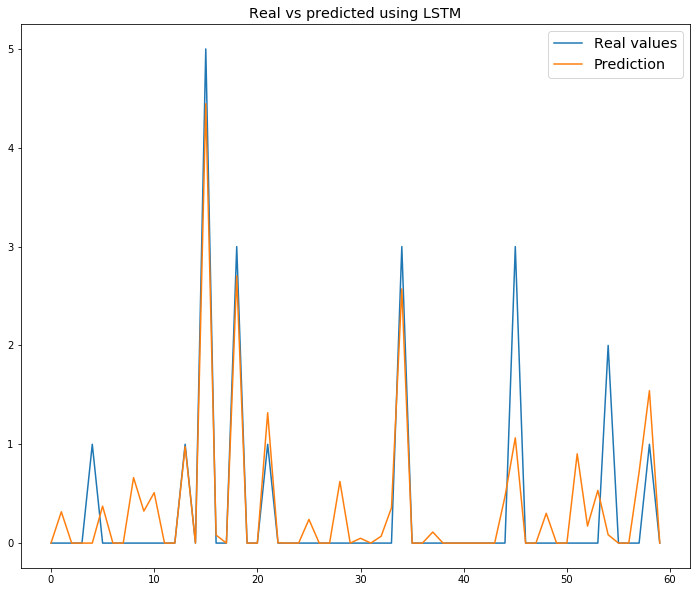

In [42]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

In [43]:
number_of_filters_CNN_LSTM = 64
number_of_nodes_CNN_LSTM = 64
model_CNN_LSTM = CNN_LSTM(window_size, no_features, number_of_filters_CNN_LSTM, number_of_nodes_CNN_LSTM)
training_history_CNN_LSTM = model_CNN_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs)
prediction_CNN_LSTM = model_CNN_LSTM.predict(X_test)
MSE_CNN_LSTM_co2_all, R2_CNN_LSTM_co2_all, residuals_CNN_LSTM_co2_all, accuracy_CNN_LSTM_co2_all, mean_error_CNN_LSTM_co2_all = model_CNN_LSTM.evaluate(
    prediction_CNN_LSTM, X_test, y_test)

Train on 2324 samples, validate on 1163 samples
Epoch 1/1200
2324/2324 [==============================] - 2s 868us/step - loss: 1.0443 - val_loss: 1.1796
Epoch 2/1200
2324/2324 [==============================] - 1s 256us/step - loss: 1.0033 - val_loss: 1.1430
Epoch 3/1200
2324/2324 [==============================] - 1s 250us/step - loss: 0.9768 - val_loss: 1.1224
Epoch 4/1200
2324/2324 [==============================] - 1s 250us/step - loss: 0.9627 - val_loss: 1.1072
Epoch 5/1200
2324/2324 [==============================] - 0s 177us/step - loss: 0.9498 - val_loss: 1.0944
Epoch 6/1200
2324/2324 [==============================] - 1s 233us/step - loss: 0.9379 - val_loss: 1.0834
Epoch 7/1200
2324/2324 [==============================] - 1s 254us/step - loss: 0.9224 - val_loss: 1.0744
Epoch 8/1200
2324/2324 [==============================] - 1s 250us/step - loss: 0.9284 - val_loss: 1.0639
Epoch 9/1200
2324/2324 [==============================] - 1s 241us/step - loss: 0.9087 - val_loss: 1.054

Epoch 77/1200
2324/2324 [==============================] - 1s 220us/step - loss: 0.7465 - val_loss: 0.8433
Epoch 78/1200
2324/2324 [==============================] - 1s 243us/step - loss: 0.7401 - val_loss: 0.8427
Epoch 79/1200
2324/2324 [==============================] - 1s 242us/step - loss: 0.7514 - val_loss: 0.8417
Epoch 80/1200
2324/2324 [==============================] - ETA: 0s - loss: 0.747 - 0s 194us/step - loss: 0.7469 - val_loss: 0.8406
Epoch 81/1200
2324/2324 [==============================] - 0s 194us/step - loss: 0.7488 - val_loss: 0.8406
Epoch 82/1200
2324/2324 [==============================] - 1s 241us/step - loss: 0.7452 - val_loss: 0.8416
Epoch 83/1200
2324/2324 [==============================] - 1s 238us/step - loss: 0.7484 - val_loss: 0.8417
Epoch 84/1200
2324/2324 [==============================] - 0s 211us/step - loss: 0.7433 - val_loss: 0.8403
Epoch 85/1200
2324/2324 [==============================] - 0s 181us/step - loss: 0.7406 - val_loss: 0.8404
Epoch 86/1200

Epoch 228/1200
2324/2324 [==============================] - 0s 191us/step - loss: 0.7051 - val_loss: 0.8170
Epoch 229/1200
2324/2324 [==============================] - 0s 199us/step - loss: 0.6940 - val_loss: 0.8164
Epoch 230/1200
2324/2324 [==============================] - 1s 254us/step - loss: 0.7021 - val_loss: 0.8162
Epoch 231/1200
2324/2324 [==============================] - 1s 233us/step - loss: 0.7038 - val_loss: 0.8144
Epoch 232/1200
2324/2324 [==============================] - 1s 224us/step - loss: 0.6957 - val_loss: 0.8157
Epoch 233/1200
2324/2324 [==============================] - 0s 189us/step - loss: 0.7011 - val_loss: 0.8169
Epoch 234/1200
2324/2324 [==============================] - 1s 241us/step - loss: 0.7015 - val_loss: 0.8147
Epoch 235/1200
2324/2324 [==============================] - 1s 233us/step - loss: 0.7022 - val_loss: 0.8152
Epoch 236/1200
2324/2324 [==============================] - 1s 241us/step - loss: 0.6858 - val_loss: 0.8154
Epoch 237/1200
2324/2324 [==

Text(0.5, 1.0, 'Real vs predicted using CNN LSTM')

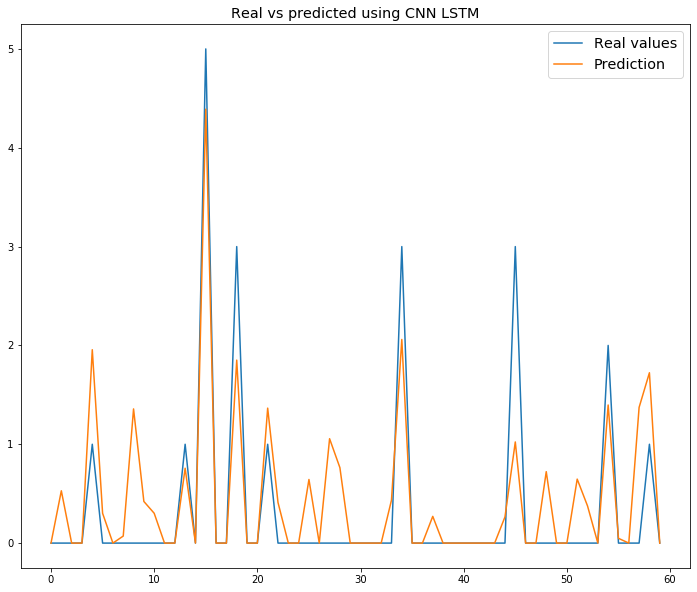

In [44]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_CNN_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using CNN LSTM')

In [45]:
pd.DataFrame([[MSE_LSTM_co2_all, R2_LSTM_co2_all, accuracy_LSTM_co2_all, mean_error_LSTM_co2_all],
              [MSE_CNN_LSTM_co2_all, R2_CNN_LSTM_co2_all, accuracy_CNN_LSTM_co2_all, mean_error_CNN_LSTM_co2_all]],
             columns=['MSE', 'R2', 'accuracy', 'mean_error'], index=['LSTM', 'CNN_LSTM'])

,MSE,R2,accuracy,mean_error
LSTM,0.710246,0.601500,0.804815,0.285469
CNN_LSTM,0.784122,0.509404,0.756664,0.348237


#### Adding sound

In [46]:
data = data_co2_noise_full
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1200
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [47]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_all, R2_LSTM_co2_noise_all, residuals_LSTM_co2_noise_all, accuracy_LSTM_co2_noise_all, mean_error_LSTM_co2_noise_all = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 2324 samples, validate on 1163 samples
Epoch 1/1200
2324/2324 [==============================] - 3s 1ms/step - loss: 1.0019 - val_loss: 1.1387
Epoch 2/1200
2324/2324 [==============================] - 2s 820us/step - loss: 0.9460 - val_loss: 1.0903
Epoch 3/1200
2324/2324 [==============================] - 2s 842us/step - loss: 0.9266 - val_loss: 1.0673
Epoch 4/1200
2324/2324 [==============================] - 2s 816us/step - loss: 0.9011 - val_loss: 1.0548
Epoch 5/1200
2324/2324 [==============================] - 2s 763us/step - loss: 0.9073 - val_loss: 1.0440
Epoch 6/1200
2324/2324 [==============================] - 2s 763us/step - loss: 0.8990 - val_loss: 1.0356
Epoch 7/1200
2324/2324 [==============================] - 2s 820us/step - loss: 0.8767 - val_loss: 1.0273
Epoch 8/1200
2324/2324 [==============================] - 2s 816us/step - loss: 0.8822 - val_loss: 1.0226
Epoch 9/1200
2324/2324 [==============================] - 2s 825us/step - loss: 0.8820 - val_loss: 1.0150


2324/2324 [==============================] - 2s 847us/step - loss: 0.7052 - val_loss: 0.8055
Epoch 154/1200
2324/2324 [==============================] - 2s 856us/step - loss: 0.7123 - val_loss: 0.8022
Epoch 155/1200
2324/2324 [==============================] - 2s 868us/step - loss: 0.7052 - val_loss: 0.8039
Epoch 156/1200
2324/2324 [==============================] - 2s 853us/step - loss: 0.7064 - val_loss: 0.7994
Epoch 157/1200
2324/2324 [==============================] - 2s 854us/step - loss: 0.7097 - val_loss: 0.8002
Epoch 158/1200
2324/2324 [==============================] - 2s 856us/step - loss: 0.7020 - val_loss: 0.8028
Epoch 159/1200
2324/2324 [==============================] - 2s 860us/step - loss: 0.6960 - val_loss: 0.8003
Epoch 160/1200
2324/2324 [==============================] - 2s 864us/step - loss: 0.7090 - val_loss: 0.7993
Epoch 161/1200
2324/2324 [==============================] - 2s 920us/step - loss: 0.7057 - val_loss: 0.7964
Epoch 162/1200
2324/2324 [=================

Epoch 229/1200
2324/2324 [==============================] - 2s 895us/step - loss: 0.6380 - val_loss: 0.7303
Epoch 230/1200
2324/2324 [==============================] - 2s 839us/step - loss: 0.6340 - val_loss: 0.7209
Epoch 231/1200
2324/2324 [==============================] - 2s 845us/step - loss: 0.6441 - val_loss: 0.7269
Epoch 232/1200
2324/2324 [==============================] - 2s 889us/step - loss: 0.6375 - val_loss: 0.7361
Epoch 233/1200
2324/2324 [==============================] - 2s 834us/step - loss: 0.6298 - val_loss: 0.7194
Epoch 234/1200
2324/2324 [==============================] - 2s 899us/step - loss: 0.6439 - val_loss: 0.7179
Epoch 235/1200
2324/2324 [==============================] - 2s 834us/step - loss: 0.6384 - val_loss: 0.7204
Epoch 236/1200
2324/2324 [==============================] - 2s 838us/step - loss: 0.6366 - val_loss: 0.7241
Epoch 237/1200
2324/2324 [==============================] - 2s 863us/step - loss: 0.6262 - val_loss: 0.7140
Epoch 238/1200
2324/2324 [==

Epoch 305/1200
2324/2324 [==============================] - 2s 872us/step - loss: 0.5983 - val_loss: 0.6945
Epoch 306/1200
2324/2324 [==============================] - 2s 873us/step - loss: 0.5875 - val_loss: 0.6987
Epoch 307/1200
2324/2324 [==============================] - 2s 919us/step - loss: 0.5958 - val_loss: 0.6956
Epoch 308/1200
2324/2324 [==============================] - 2s 838us/step - loss: 0.5958 - val_loss: 0.6932
Epoch 309/1200
2324/2324 [==============================] - 2s 958us/step - loss: 0.5899 - val_loss: 0.6913
Epoch 310/1200
2324/2324 [==============================] - 2s 857us/step - loss: 0.5939 - val_loss: 0.6868
Epoch 311/1200
2324/2324 [==============================] - 2s 864us/step - loss: 0.5843 - val_loss: 0.6971
Epoch 312/1200
2324/2324 [==============================] - 2s 864us/step - loss: 0.5909 - val_loss: 0.6931
Epoch 313/1200
2324/2324 [==============================] - 2s 851us/step - loss: 0.5926 - val_loss: 0.6888
Epoch 314/1200
2324/2324 [==

In [48]:
pd.DataFrame([[MSE_LSTM_co2_room1, R2_LSTM_co2_room1, accuracy_LSTM_co2_room1, mean_error_LSTM_co2_room1],
              [MSE_LSTM_co2_room2, R2_LSTM_co2_room2, accuracy_LSTM_co2_room2, mean_error_LSTM_co2_room2],
              [MSE_LSTM_co2_room3, R2_LSTM_co2_room3, accuracy_LSTM_co2_room3, mean_error_LSTM_co2_room3],
              [MSE_LSTM_co2_room4, R2_LSTM_co2_room4, accuracy_LSTM_co2_room4, mean_error_LSTM_co2_room4],
              [MSE_LSTM_co2_room5, R2_LSTM_co2_room5, accuracy_LSTM_co2_room5, mean_error_LSTM_co2_room5],
              [MSE_LSTM_co2_all, R2_LSTM_co2_all, accuracy_LSTM_co2_all, mean_error_LSTM_co2_all]],
             columns=['MSE', 'R2', 'accuracy', 'mean_error'], index=['Room 1', 'Room 2', 'Room 3', 'Room 4', 'Room 5', 'All rooms'])

,MSE,R2,accuracy,mean_error
Room 1,0.523178,0.391485,0.830357,0.223214
Room 2,0.596682,0.474122,0.790179,0.281250
Room 3,1.014314,0.573931,0.741071,0.455357
Room 4,0.671482,0.682148,0.816964,0.263393
Room 5,0.532769,0.351533,0.794643,0.241071
All rooms,0.710246,0.601500,0.804815,0.285469


In [49]:
pd.DataFrame([[MSE_LSTM_co2_noise_room1, R2_LSTM_co2_noise_room1, accuracy_LSTM_co2_noise_room1, mean_error_LSTM_co2_noise_room1],
              [MSE_LSTM_co2_noise_room2, R2_LSTM_co2_noise_room2, accuracy_LSTM_co2_noise_room2, mean_error_LSTM_co2_noise_room2],
              [MSE_LSTM_co2_noise_room3, R2_LSTM_co2_noise_room3, accuracy_LSTM_co2_noise_room3, mean_error_LSTM_co2_noise_room3],
              [MSE_LSTM_co2_noise_room4, R2_LSTM_co2_noise_room4, accuracy_LSTM_co2_noise_room4, mean_error_LSTM_co2_noise_room4],
              [MSE_LSTM_co2_noise_room5, R2_LSTM_co2_noise_room5, accuracy_LSTM_co2_noise_room5, mean_error_LSTM_co2_noise_room5],
              [MSE_LSTM_co2_noise_all, R2_LSTM_co2_noise_all, accuracy_LSTM_co2_noise_all, mean_error_LSTM_co2_noise_all]],
              columns=['MSE', 'R2', 'accuracy', 'mean_error'], index=['Room 1', 'Room 2', 'Room 3', 'Room 4', 'Room 5', 'All rooms'])

,MSE,R2,accuracy,mean_error
Room 1,0.713446,-0.156142,0.839286,0.272321
Room 2,0.598824,0.469518,0.803571,0.267857
Room 3,0.962418,0.633904,0.745536,0.455357
Room 4,0.652007,0.686114,0.794643,0.276786
Room 5,0.535265,0.347917,0.794643,0.236607
All rooms,0.660035,0.655467,0.828031,0.250215


# Change sample frequency to 15 min

In [30]:
data = pd.read_csv('data_co2_occ_full_numerical_15.csv', sep=';', decimal=',', index_col=0)
data.index = pd.to_datetime(data.index, utc=True)

# account for the lag in co2 increase and people entering the room

data['co2'] = data['co2'].shift(3)
data['co2'] = data['co2'].fillna(method='bfill')

data['noise'] = data['noise'].shift(4)
data['noise'] = data['noise'].fillna(method='bfill')

data_co2_room1 = data.loc[data['room'] == 1, ['occupancy', 'co2']]
data_co2_room2 = data.loc[data['room'] == 2, ['occupancy', 'co2']]
data_co2_room3 = data.loc[data['room'] == 3, ['occupancy', 'co2']]
data_co2_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2']]
data_co2_room5 = data.loc[data['room'] == 5, ['occupancy', 'co2']]

data_co2_noise_room1 = data.loc[data['room'] == 1, ['occupancy', 'co2', 'noise']]
data_co2_noise_room2 = data.loc[data['room'] == 2, ['occupancy', 'co2', 'noise']]
data_co2_noise_room3 = data.loc[data['room'] == 3, ['occupancy', 'co2', 'noise']]
data_co2_noise_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2', 'noise']]
data_co2_noise_room5 = data.loc[data['room'] == 5, ['occupancy', 'co2', 'noise']]

data_co2_noise_humidity_temperature_room4 = data.loc[data['room'] == 4, ['occupancy', 'co2', 'noise', 'humidity', 'temperature']]

data_co2_full = data[['occupancy', 'co2']]
data_co2_noise_full = data[['occupancy', 'co2', 'noise']]

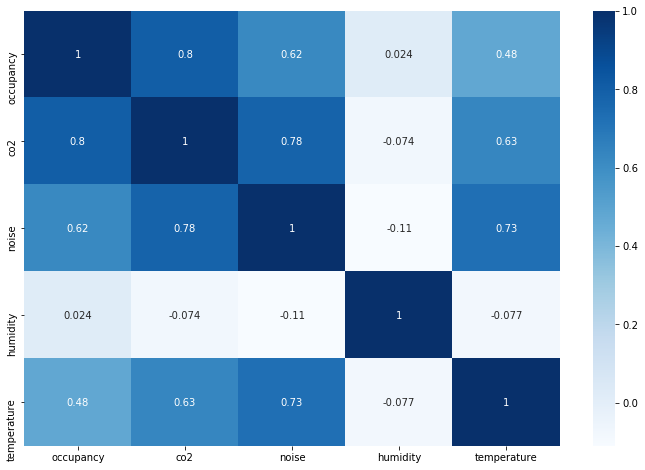

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(data_co2_noise_humidity_temperature_room4.corr(),cmap='Blues',annot=True)

Text(0.5, 1, 'Occupancy vs CO_2')

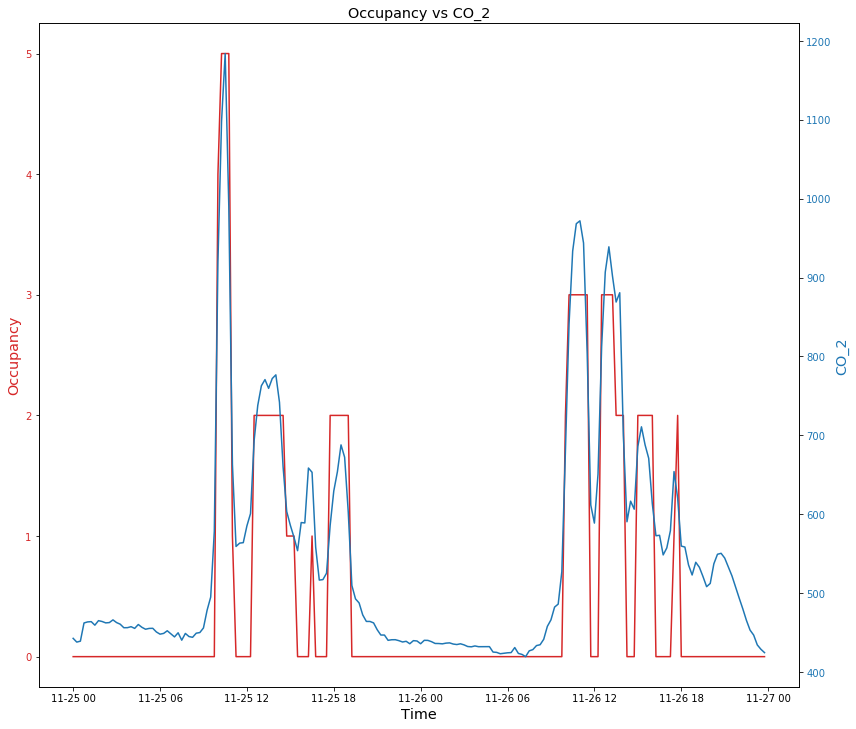

In [32]:
data_co2_room = data_co2_room4

data_cut = (data_co2_room.loc[(data_co2_room.index.day==25) & (data_co2_room.index.month==11)]).append(data_co2_room.loc[(data_co2_room.index.day==26) & (data_co2_room.index.month==11)])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupancy', color=color)

ax1.plot(data_cut['occupancy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CO_2', color=color)

ax2.plot(data_cut['co2'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Occupancy vs CO_2')

Text(0.5, 1, 'Occupancy vs Sound')

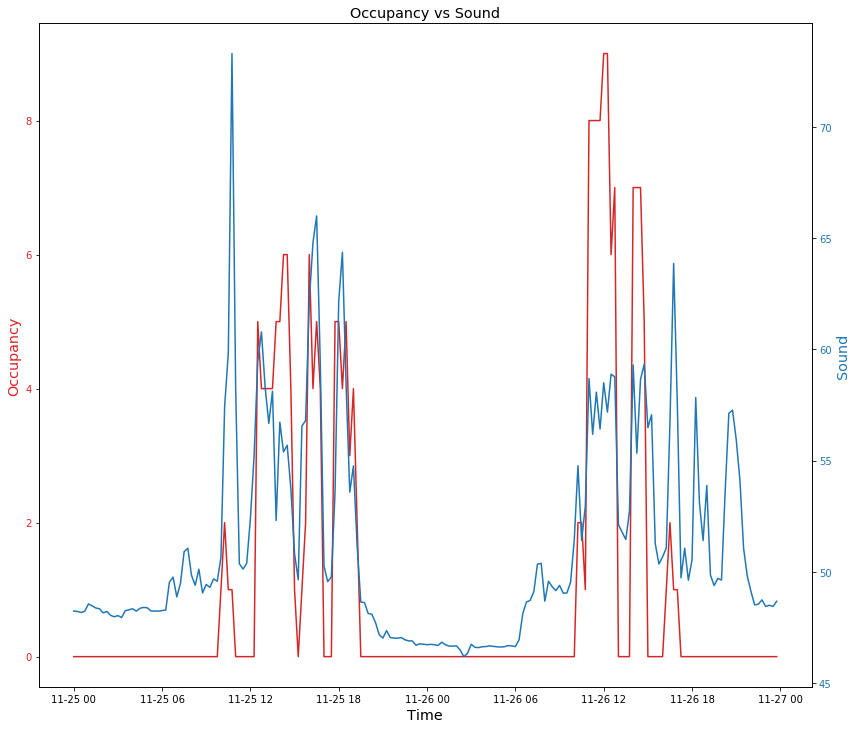

In [33]:
data_noise_room = data_co2_noise_room3

data_cut = (data_noise_room.loc[(data_noise_room.index.day==25) & (data_noise_room.index.month==11)]).append(data_noise_room.loc[(data_noise_room.index.day==26) & (data_noise_room.index.month==11)])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupancy', color=color)

ax1.plot(data_cut['occupancy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sound', color=color)

ax2.plot(data_cut['noise'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Occupancy vs Sound')


In [24]:
data = data_co2_room4
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

In [7]:
number_of_epochs = 1000
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [8]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_room4_15, R2_LSTM_co2_room4_15, residuals_LSTM_co2_room4_15, accuracy_LSTM_co2_room4_15, mean_error_LSTM_co2_room4_15 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 916 samples, validate on 459 samples
Epoch 1/1000
916/916 [==============================] - 1s 2ms/step - loss: 1.1959 - val_loss: 1.0060
Epoch 2/1000
916/916 [==============================] - 1s 548us/step - loss: 1.1037 - val_loss: 0.9366
Epoch 3/1000
916/916 [==============================] - 0s 535us/step - loss: 1.0437 - val_loss: 0.8987
Epoch 4/1000
916/916 [==============================] - 1s 567us/step - loss: 0.9915 - val_loss: 0.8831
Epoch 5/1000
916/916 [==============================] - 1s 547us/step - loss: 0.9764 - val_loss: 0.8756
Epoch 6/1000
916/916 [==============================] - 1s 567us/step - loss: 0.9604 - val_loss: 0.8707
Epoch 7/1000
916/916 [==============================] - 1s 567us/step - loss: 0.9482 - val_loss: 0.8666
Epoch 8/1000
916/916 [==============================] - 1s 574us/step - loss: 0.9374 - val_loss: 0.8620
Epoch 9/1000
916/916 [==============================] - 1s 559us/step - loss: 0.9275 - val_loss: 0.8570
Epoch 10/1000
916/91

916/916 [==============================] - 1s 776us/step - loss: 0.7065 - val_loss: 0.6924
Epoch 156/1000
916/916 [==============================] - 1s 796us/step - loss: 0.7077 - val_loss: 0.6925
Epoch 157/1000
916/916 [==============================] - 1s 800us/step - loss: 0.7060 - val_loss: 0.6913
Epoch 158/1000
916/916 [==============================] - 1s 762us/step - loss: 0.7052 - val_loss: 0.6900
Epoch 159/1000
916/916 [==============================] - 1s 793us/step - loss: 0.7064 - val_loss: 0.6891
Epoch 160/1000
916/916 [==============================] - 1s 876us/step - loss: 0.7070 - val_loss: 0.6888
Epoch 161/1000
916/916 [==============================] - 1s 981us/step - loss: 0.7081 - val_loss: 0.6876
Epoch 162/1000
916/916 [==============================] - 1s 910us/step - loss: 0.7041 - val_loss: 0.6879
Epoch 163/1000
916/916 [==============================] - 1s 921us/step - loss: 0.6894 - val_loss: 0.6880
Epoch 164/1000
916/916 [==============================] - 1s 

916/916 [==============================] - 1s 767us/step - loss: 0.6489 - val_loss: 0.6383
Epoch 310/1000
916/916 [==============================] - 1s 773us/step - loss: 0.6611 - val_loss: 0.6386
Epoch 311/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.6564 - val_loss: 0.6386
Epoch 312/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.6506 - val_loss: 0.6392
Epoch 313/1000
916/916 [==============================] - 1s 801us/step - loss: 0.6549 - val_loss: 0.6384
Epoch 314/1000
916/916 [==============================] - 1s 770us/step - loss: 0.6483 - val_loss: 0.6371
Epoch 315/1000
916/916 [==============================] - 1s 788us/step - loss: 0.6586 - val_loss: 0.6395
Epoch 316/1000
916/916 [==============================] - 1s 792us/step - loss: 0.6516 - val_loss: 0.6374
Epoch 317/1000
916/916 [==============================] - 1s 794us/step - loss: 0.6496 - val_loss: 0.6376
Epoch 318/1000
916/916 [==============================] - 1s 833u

916/916 [==============================] - 1s 933us/step - loss: 0.6102 - val_loss: 0.5999
Epoch 464/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.6058 - val_loss: 0.6000
Epoch 465/1000
916/916 [==============================] - 1s 929us/step - loss: 0.6104 - val_loss: 0.5948
Epoch 466/1000
916/916 [==============================] - 1s 931us/step - loss: 0.6130 - val_loss: 0.5973
Epoch 467/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.5993 - val_loss: 0.5937
Epoch 468/1000
916/916 [==============================] - 1s 787us/step - loss: 0.6085 - val_loss: 0.5947
Epoch 469/1000
916/916 [==============================] - 1s 807us/step - loss: 0.6020 - val_loss: 0.5943
Epoch 470/1000
916/916 [==============================] - 1s 798us/step - loss: 0.6119 - val_loss: 0.5959
Epoch 471/1000
916/916 [==============================] - 1s 765us/step - loss: 0.6027 - val_loss: 0.5946
Epoch 472/1000
916/916 [==============================] - 1s 772u

916/916 [==============================] - 1s 846us/step - loss: 0.5596 - val_loss: 0.5480
Epoch 618/1000
916/916 [==============================] - 1s 815us/step - loss: 0.5738 - val_loss: 0.5498
Epoch 619/1000
916/916 [==============================] - 1s 946us/step - loss: 0.5837 - val_loss: 0.5470
Epoch 620/1000
916/916 [==============================] - 1s 771us/step - loss: 0.5770 - val_loss: 0.5398
Epoch 621/1000
916/916 [==============================] - 1s 791us/step - loss: 0.5643 - val_loss: 0.5499
Epoch 622/1000
916/916 [==============================] - 1s 913us/step - loss: 0.5682 - val_loss: 0.5432
Epoch 623/1000
916/916 [==============================] - 1s 781us/step - loss: 0.5661 - val_loss: 0.5527
Epoch 624/1000
916/916 [==============================] - 1s 833us/step - loss: 0.5704 - val_loss: 0.5425
Epoch 625/1000
916/916 [==============================] - 1s 946us/step - loss: 0.5651 - val_loss: 0.5379
Epoch 626/1000
916/916 [==============================] - 1s 

Text(0.5, 1.0, 'Real vs predicted using LSTM')

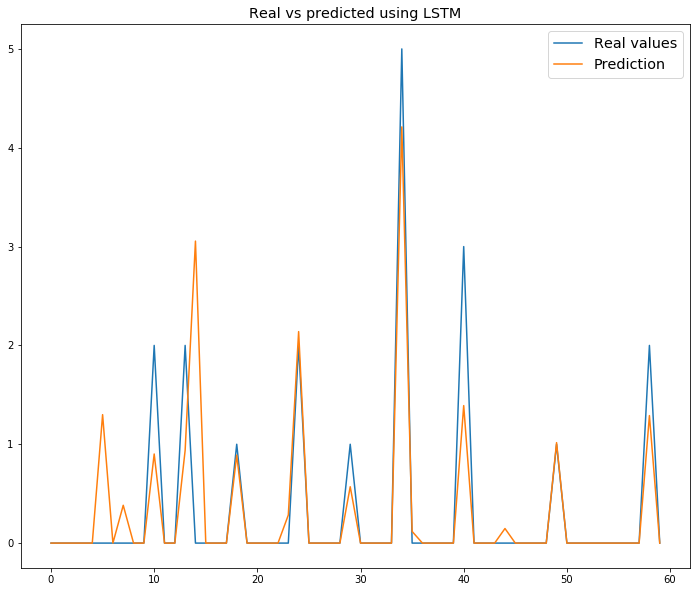

In [13]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

### Adding sound

In [14]:
data = data_co2_noise_room4
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1000
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [15]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_room4_15, R2_LSTM_co2_noise_room4_15, residuals_LSTM_co2_noise_room4_15, accuracy_LSTM_co2_noise_room4_15, mean_error_LSTM_co2_noise_room4_15 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 916 samples, validate on 459 samples
Epoch 1/1000
916/916 [==============================] - 2s 2ms/step - loss: 1.2440 - val_loss: 1.0817
Epoch 2/1000
916/916 [==============================] - 1s 619us/step - loss: 1.2426 - val_loss: 1.0795
Epoch 3/1000
916/916 [==============================] - 1s 581us/step - loss: 1.2575 - val_loss: 1.0782
Epoch 4/1000
916/916 [==============================] - 1s 649us/step - loss: 1.2461 - val_loss: 1.0775
Epoch 5/1000
916/916 [==============================] - 1s 586us/step - loss: 1.2418 - val_loss: 1.0769
Epoch 6/1000
916/916 [==============================] - 1s 587us/step - loss: 1.2499 - val_loss: 1.0767
Epoch 7/1000
916/916 [==============================] - 1s 590us/step - loss: 1.2493 - val_loss: 1.0765
Epoch 8/1000
916/916 [==============================] - 1s 589us/step - loss: 1.2441 - val_loss: 1.0764
Epoch 9/1000
916/916 [==============================] - 1s 587us/step - loss: 1.2483 - val_loss: 1.0764
Epoch 10/1000
916/91

916/916 [==============================] - 1s 778us/step - loss: 0.7420 - val_loss: 0.7296
Epoch 156/1000
916/916 [==============================] - 1s 791us/step - loss: 0.7378 - val_loss: 0.7261
Epoch 157/1000
916/916 [==============================] - 1s 839us/step - loss: 0.7279 - val_loss: 0.7265
Epoch 158/1000
916/916 [==============================] - 1s 803us/step - loss: 0.7350 - val_loss: 0.7269
Epoch 159/1000
916/916 [==============================] - 1s 847us/step - loss: 0.7392 - val_loss: 0.7260
Epoch 160/1000
916/916 [==============================] - 1s 769us/step - loss: 0.7303 - val_loss: 0.7259
Epoch 161/1000
916/916 [==============================] - ETA: 0s - loss: 0.733 - 1s 814us/step - loss: 0.7358 - val_loss: 0.7241
Epoch 162/1000
916/916 [==============================] - 1s 691us/step - loss: 0.7358 - val_loss: 0.7239
Epoch 163/1000
916/916 [==============================] - 1s 879us/step - loss: 0.7263 - val_loss: 0.7225
Epoch 164/1000
916/916 [=============

916/916 [==============================] - 1s 824us/step - loss: 0.6163 - val_loss: 0.5696
Epoch 310/1000
916/916 [==============================] - 1s 822us/step - loss: 0.6222 - val_loss: 0.5647
Epoch 311/1000
916/916 [==============================] - 1s 824us/step - loss: 0.6135 - val_loss: 0.5638
Epoch 312/1000
916/916 [==============================] - 1s 844us/step - loss: 0.6140 - val_loss: 0.5762
Epoch 313/1000
916/916 [==============================] - 1s 965us/step - loss: 0.6170 - val_loss: 0.5612
Epoch 314/1000
916/916 [==============================] - 1s 890us/step - loss: 0.6101 - val_loss: 0.5707
Epoch 315/1000
916/916 [==============================] - 1s 835us/step - loss: 0.6138 - val_loss: 0.5591
Epoch 316/1000
916/916 [==============================] - 1s 827us/step - loss: 0.6103 - val_loss: 0.5603
Epoch 317/1000
916/916 [==============================] - 1s 824us/step - loss: 0.6069 - val_loss: 0.5850
Epoch 318/1000
916/916 [==============================] - 1s 

916/916 [==============================] - 1s 835us/step - loss: 0.5329 - val_loss: 0.4805
Epoch 464/1000
916/916 [==============================] - 1s 1000us/step - loss: 0.5310 - val_loss: 0.4788
Epoch 465/1000
916/916 [==============================] - 1s 824us/step - loss: 0.5185 - val_loss: 0.4779
Epoch 466/1000
916/916 [==============================] - 1s 857us/step - loss: 0.5249 - val_loss: 0.4874
Epoch 467/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.5382 - val_loss: 0.4752
Epoch 468/1000
916/916 [==============================] - 1s 935us/step - loss: 0.5354 - val_loss: 0.4791
Epoch 469/1000
916/916 [==============================] - 1s 847us/step - loss: 0.5308 - val_loss: 0.4914
Epoch 470/1000
916/916 [==============================] - 1s 816us/step - loss: 0.5355 - val_loss: 0.4764
Epoch 471/1000
916/916 [==============================] - 1s 923us/step - loss: 0.5279 - val_loss: 0.4770
Epoch 472/1000
916/916 [==============================] - 1s 9

916/916 [==============================] - 1s 849us/step - loss: 0.4894 - val_loss: 0.4482
Epoch 618/1000
916/916 [==============================] - 1s 937us/step - loss: 0.4934 - val_loss: 0.4437
Epoch 619/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.4806 - val_loss: 0.4599
Epoch 620/1000
916/916 [==============================] - 1s 828us/step - loss: 0.4921 - val_loss: 0.4814
Epoch 621/1000
916/916 [==============================] - 1s 870us/step - loss: 0.4809 - val_loss: 0.4365
Epoch 622/1000
916/916 [==============================] - 1s 1ms/step - loss: 0.4851 - val_loss: 0.4676
Epoch 623/1000
916/916 [==============================] - 1s 877us/step - loss: 0.4964 - val_loss: 0.4352
Epoch 624/1000
916/916 [==============================] - 1s 883us/step - loss: 0.4836 - val_loss: 0.4375
Epoch 625/1000
916/916 [==============================] - 1s 872us/step - loss: 0.4794 - val_loss: 0.4501
Epoch 626/1000
916/916 [==============================] - 1s 1ms/

Text(0.5, 1.0, 'Real vs predicted using LSTM')

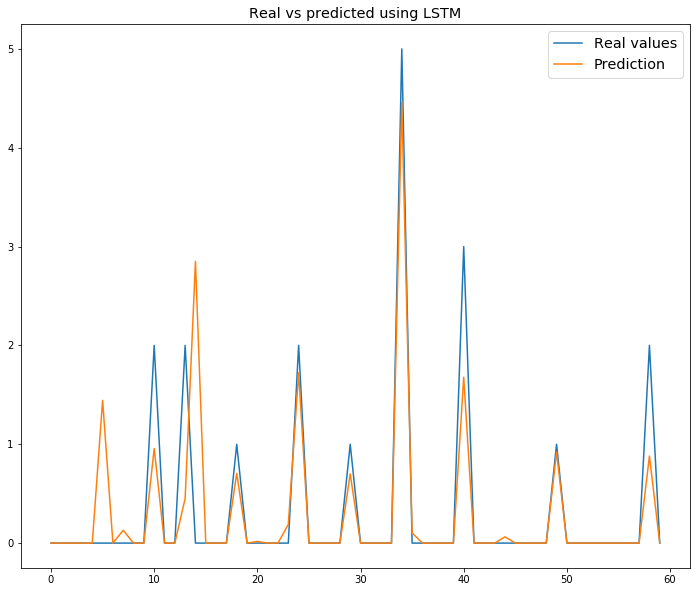

In [16]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

## All rooms  together
### $CO_2$ only

In [17]:
data = data_co2_full
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1000
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [18]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_full_15, R2_LSTM_co2_full_15, residuals_LSTM_co2_full_15, accuracy_LSTM_co2_full_15, mean_error_LSTM_co2_full_15 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 4671 samples, validate on 2336 samples
Epoch 1/1000
4671/4671 [==============================] - 6s 1ms/step - loss: 1.1485 - val_loss: 1.0426
Epoch 2/1000
4671/4671 [==============================] - 4s 823us/step - loss: 1.0559 - val_loss: 0.9861
Epoch 3/1000
4671/4671 [==============================] - 4s 750us/step - loss: 1.0254 - val_loss: 0.9592
Epoch 4/1000
4671/4671 [==============================] - 4s 754us/step - loss: 1.0018 - val_loss: 0.9479
Epoch 5/1000
4671/4671 [==============================] - 3s 737us/step - loss: 0.9976 - val_loss: 0.9392
Epoch 6/1000
4671/4671 [==============================] - 3s 737us/step - loss: 0.9907 - val_loss: 0.9327
Epoch 7/1000
4671/4671 [==============================] - 4s 749us/step - loss: 0.9802 - val_loss: 0.9278
Epoch 8/1000
4671/4671 [==============================] - 4s 815us/step - loss: 0.9724 - val_loss: 0.9229
Epoch 9/1000
4671/4671 [==============================] - 4s 900us/step - loss: 0.9773 - val_loss: 0.9187


4671/4671 [==============================] - 4s 766us/step - loss: 0.6539 - val_loss: 0.6910
Epoch 209/1000
4671/4671 [==============================] - 3s 739us/step - loss: 0.6516 - val_loss: 0.6909
Epoch 210/1000
2336/2336 [==============================] - 1s 242us/step


Text(0.5, 1.0, 'Real vs predicted using LSTM')

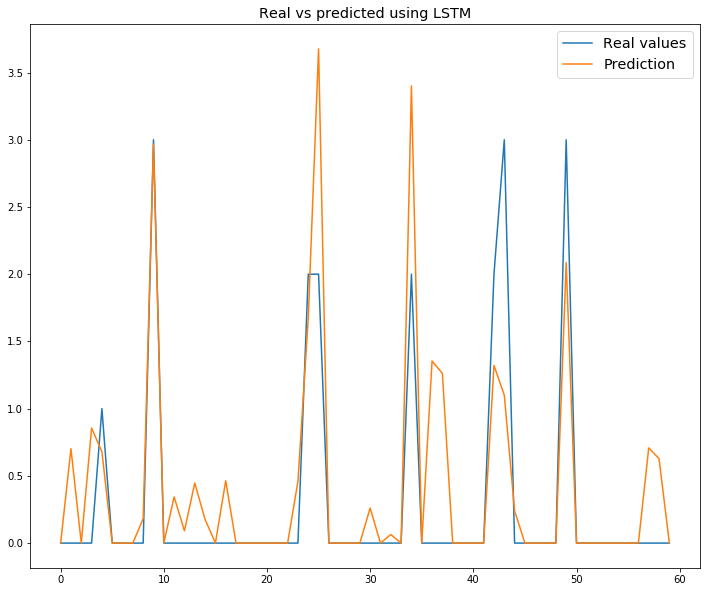

In [19]:
slice_start = 160
slice_end = 220

p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

### Adding sound

In [20]:
data = data_co2_noise_full
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

number_of_epochs = 1000
window_size = 32
batch_size = 64

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

In [21]:
number_of_nodes_LSTM = 32
model_LSTM = LSTM(window_size, no_features, number_of_nodes_LSTM)
training_history_LSTM = model_LSTM.fit(X_train, X_test, y_train, y_test, number_of_epochs, batch_size)
prediction_LSTM = model_LSTM.predict(X_test)
MSE_LSTM_co2_noise_full_15, R2_LSTM_co2_noise_full_15, residuals_LSTM_co2_noise_full_15, accuracy_LSTM_co2_noise_full_15, mean_error_LSTM_co2_noise_full_15 = model_LSTM.evaluate(prediction_LSTM, X_test, y_test)

Train on 4671 samples, validate on 2336 samples
Epoch 1/1000
4671/4671 [==============================] - 4s 792us/step - loss: 1.0503 - val_loss: 0.9638
Epoch 2/1000
4671/4671 [==============================] - 4s 793us/step - loss: 1.0019 - val_loss: 0.9499
Epoch 3/1000
4671/4671 [==============================] - 4s 767us/step - loss: 0.9912 - val_loss: 0.9393
Epoch 4/1000
4671/4671 [==============================] - 3s 744us/step - loss: 0.9831 - val_loss: 0.9297
Epoch 5/1000
4671/4671 [==============================] - 4s 769us/step - loss: 0.9719 - val_loss: 0.9222
Epoch 6/1000
4671/4671 [==============================] - 3s 746us/step - loss: 0.9730 - val_loss: 0.9146
Epoch 7/1000
4671/4671 [==============================] - 3s 737us/step - loss: 0.9594 - val_loss: 0.9075
Epoch 8/1000
4671/4671 [==============================] - 3s 748us/step - loss: 0.9546 - val_loss: 0.9021
Epoch 9/1000
4671/4671 [==============================] - 3s 724us/step - loss: 0.9478 - val_loss: 0.895

4671/4671 [==============================] - 3s 711us/step - loss: 0.6452 - val_loss: 0.6784
Epoch 154/1000
4671/4671 [==============================] - 3s 712us/step - loss: 0.6405 - val_loss: 0.6870
Epoch 155/1000
4671/4671 [==============================] - 3s 720us/step - loss: 0.6455 - val_loss: 0.6746
Epoch 156/1000
4671/4671 [==============================] - 4s 759us/step - loss: 0.6369 - val_loss: 0.6797
Epoch 157/1000
4671/4671 [==============================] - 3s 717us/step - loss: 0.6397 - val_loss: 0.6779
Epoch 158/1000
4671/4671 [==============================] - 3s 698us/step - loss: 0.6397 - val_loss: 0.6840
Epoch 159/1000
4671/4671 [==============================] - 3s 708us/step - loss: 0.6354 - val_loss: 0.6770
Epoch 160/1000
4671/4671 [==============================] - 3s 694us/step - loss: 0.6413 - val_loss: 0.6974
Epoch 161/1000
4671/4671 [==============================] - 3s 721us/step - loss: 0.6314 - val_loss: 0.6741
Epoch 162/1000
4671/4671 [=================

Epoch 229/1000
4671/4671 [==============================] - 3s 672us/step - loss: 0.5914 - val_loss: 0.6568
Epoch 230/1000
4671/4671 [==============================] - 3s 650us/step - loss: 0.5818 - val_loss: 0.6492
Epoch 231/1000
4671/4671 [==============================] - 3s 659us/step - loss: 0.5812 - val_loss: 0.6583
Epoch 232/1000
4671/4671 [==============================] - 3s 658us/step - loss: 0.5890 - val_loss: 0.6528
Epoch 233/1000
4671/4671 [==============================] - 3s 739us/step - loss: 0.5878 - val_loss: 0.6439
Epoch 234/1000
4671/4671 [==============================] - 3s 698us/step - loss: 0.5839 - val_loss: 0.6499
Epoch 235/1000
4671/4671 [==============================] - 3s 710us/step - loss: 0.5837 - val_loss: 0.6730
Epoch 236/1000
4671/4671 [==============================] - 3s 660us/step - loss: 0.5814 - val_loss: 0.6526
Epoch 237/1000
4671/4671 [==============================] - 3s 660us/step - loss: 0.5807 - val_loss: 0.6507
Epoch 238/1000
4671/4671 [==

Epoch 305/1000
4671/4671 [==============================] - 3s 698us/step - loss: 0.5484 - val_loss: 0.6286
Epoch 306/1000
4671/4671 [==============================] - 3s 731us/step - loss: 0.5372 - val_loss: 0.6287
Epoch 307/1000
4671/4671 [==============================] - 3s 701us/step - loss: 0.5408 - val_loss: 0.6282
Epoch 308/1000
4671/4671 [==============================] - 3s 747us/step - loss: 0.5424 - val_loss: 0.6275
Epoch 309/1000
4671/4671 [==============================] - 4s 795us/step - loss: 0.5436 - val_loss: 0.6312
Epoch 310/1000
4671/4671 [==============================] - 3s 685us/step - loss: 0.5608 - val_loss: 0.6469
Epoch 311/1000
4671/4671 [==============================] - 3s 726us/step - loss: 0.5477 - val_loss: 0.6513
Epoch 312/1000
4671/4671 [==============================] - 3s 698us/step - loss: 0.5694 - val_loss: 0.6252
Epoch 313/1000
4671/4671 [==============================] - 3s 744us/step - loss: 0.5553 - val_loss: 0.6212
Epoch 314/1000
4671/4671 [==

Text(0.5, 1.0, 'Real vs predicted using LSTM')

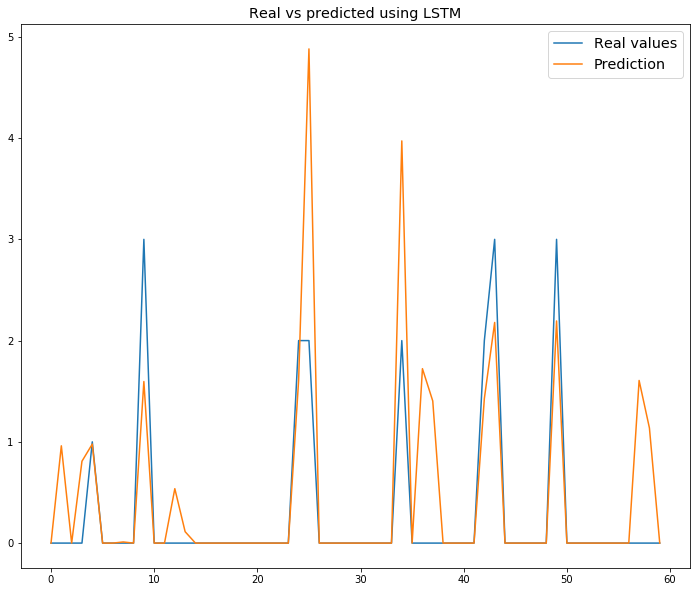

In [22]:
p1 = plt.plot(y_test[slice_start:slice_end])
p2 = plt.plot(prediction_LSTM[slice_start:slice_end])

plt.legend((p1[0], p2[0]), ('Real values', 'Prediction'))

plt.title('Real vs predicted using LSTM')

In [23]:
pd.DataFrame([[MSE_LSTM_co2_room4_15, R2_LSTM_co2_room4_15, accuracy_LSTM_co2_room4_15, mean_error_LSTM_co2_room4_15], 
              [MSE_LSTM_co2_noise_room4_15, R2_LSTM_co2_noise_room4_15, accuracy_LSTM_co2_noise_room4_15, mean_error_LSTM_co2_noise_room4_15],
              [MSE_LSTM_co2_full_15, R2_LSTM_co2_full_15, accuracy_LSTM_co2_full_15, mean_error_LSTM_co2_full_15 ],
              [MSE_LSTM_co2_noise_full_15, R2_LSTM_co2_noise_full_15, accuracy_LSTM_co2_noise_full_15, mean_error_LSTM_co2_noise_full_15]],
              columns=['MSE', 'R2', 'accuracy', 'mean_error'], index=['Room 4 CO_2', 'Room 4 CO_2 + Sound', 'Full CO_2', 'Full CO_2 + Sound'])

,MSE,R2,accuracy,mean_error
Room 4 CO_2,0.552814,0.686940,0.823529,0.235294
Room 4 CO_2 + Sound,0.482531,0.758407,0.840959,0.187364
Full CO_2,0.674150,0.596541,0.809932,0.273116
Full CO_2 + Sound,0.604587,0.673678,0.827055,0.236301
